
Rastrigin:

GP EI: derivation of exact partial-order GP EI derivatives wrt **x1**, **x2**

In [ ]:
#pip install pyGPGO


In [ ]:
### Import:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from joblib import Parallel, delayed
from numpy.linalg import solve
from scipy.optimize import minimize, approx_fprime
from scipy.optimize._numdiff import _dense_difference, _compute_absolute_step, approx_derivative, _adjust_scheme_to_bounds, _prepare_bounds
from scipy.spatial.distance import cdist
from scipy.stats import norm
import time

warnings.filterwarnings("ignore", category=RuntimeWarning)


In [ ]:
n_start_AcqFunc = 100 #multi-start iterations to avoid local optima in AcqFunc optimization


In [ ]:
### Inputs:

n_test = 500
eps = 1e-08

util_grad_exact = 'dEI_GP'
util_grad_approx = 'ExpectedImprovement'

n_init = 5 # random initialisations
iters = 20
opt = True

In [ ]:
### Objective Function - Rastrigin(x) 2-D:

def objfunc(x1_training, x2_training):
        return  operator * (10 * dim + x1_training** 2 - 10 * np.cos(2 * np.pi * x1_training)
                                    + x2_training** 2 - 10 * np.cos(2 * np.pi * x2_training)
                          )
    
# Constraints:
lb = -5.12 
ub = +5.12
    
# Input array dimension(s):
dim = 2

# 2-D inputs' parameter bounds:
param = {'x1_training': ('cont', [lb, ub]),
             'x2_training': ('cont', [lb, ub])}

# True y bounds:
operator = -1
y_global_orig = 0 # targets global minimum

# Test data:
x1_test = np.linspace(lb, ub, n_test) 
x2_test = np.linspace(lb, ub, n_test)
  
x_test = np.column_stack((x1_test,x2_test))


In [ ]:
### Cumulative Regret Calculator:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list
  

In [ ]:
### Surrogate derivatives: 

cov_func = squaredExponential()

class dGaussianProcess(GaussianProcess):
    l = GaussianProcess(cov_func, optimize=opt).getcovparams()['l']
    sigmaf = GaussianProcess(cov_func, optimize=opt).getcovparams()['sigmaf']
    sigman = GaussianProcess(cov_func, optimize=opt).getcovparams()['sigman']

    def AcqGrad(self, Xstar):
        Xstar = np.atleast_2d(Xstar)
        Kstar = squaredExponential.K(self, self.X, Xstar).T
        dKstar = Kstar * cdist(self.X, Xstar).T * -1
        
        v = solve(self.L, Kstar.T)
        dv = solve(self.L, dKstar.T)
        
        ds = -2 * np.diag(np.dot(dv.T, v))
        dm = np.dot(dKstar, self.alpha)
        return ds, dm
        

In [ ]:
class Acquisition_new(Acquisition):    
    def __init__(self, mode, eps=1e-08, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'dEI_GP': self.dEI_GP
        }

        self.f = mode_dict[mode]
    
    def dEI_GP(self, tau, mean, std, ds, dm):
        gamma = (mean - tau - self.eps) / (std + self.eps)
        gamma_h = (mean - tau) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)
        
        f = (std + self.eps) * (gamma * norm.cdf(gamma) + norm.pdf(gamma))
        df1 = f / (std + self.eps) * dsdx 
        df2 = (std + self.eps) * norm.cdf(gamma) * dmdx
        df = df1 + df2

        df_arr = []

        for j in range(0, dim):
          df_arr.append([df])
        return f, np.asarray(df_arr).transpose()

    def d_eval(self, tau, mean, std, ds, dm):
    
        return self.f(tau, mean, std, ds, dm, **self.params)
        

In [ ]:
## dGPGO:

class dGPGO(GPGO):  
    n_start = n_start_AcqFunc
    eps = 1e-08

    def d_optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfunc,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])

        self.x_best = x_best
        self.f_best = f_best
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr

        return x_best, f_best
    
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self.logger._printInit(self)
        for iteration in range(max_iter):
            self.d_optimizeAcq()
            self.updateGP()
            self.logger._printCurrent(self)

    def acqfunc(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        ds, dm = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(-self.tau, new_mean, new_std, ds=ds, dm=dm)
        
        return -f, df

    def acqfunc_h(self, xnew, n_start=n_start_AcqFunc, eps=eps):
        f = self.acqfunc(xnew)[0]
        
        new_mean_h, new_var_h = self.GP.predict(xnew + eps, return_std=True)
        new_std_h = np.sqrt(new_var_h + eps)
        ds_h, dm_h = self.GP.AcqGrad(xnew + eps)
        f_h = self.A.d_eval(-self.tau, new_mean_h, new_std_h, ds=ds_h, dm=dm_h)[0]
        
        approx_grad = (-f_h - f)/eps
        return approx_grad


In [ ]:
###Reproducible set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 6
run_num_7 = 7
run_num_8 = 8
run_num_9 = 9
run_num_10 = 10
run_num_11 = 11
run_num_12 = 12
run_num_13 = 13
run_num_14 = 14
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [ ]:
start_approx = time.time()
start_approx


1623409277.7587016

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_1)
surrogate_approx_1 = GaussianProcess(cov_func, optimize=opt)

approx_1 = GPGO(surrogate_approx_1, Acquisition(util_grad_approx), objfunc, param)
approx_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-0.84969467  2.25612281]. 	  -20.33436270766351 	 -19.908403246996286
init   	 [-5.1188288  -2.02411446]. 	  -33.07414982069084 	 -19.908403246996286
init   	 [-3.61721968 -4.17445279]. 	  -53.347974723929894 	 -19.908403246996286
init   	 [-3.21269544 -1.58145816]. 	  -39.218472310354045 	 -19.908403246996286
init   	 [-1.05710106  0.39748336]. 	  -19.908403246996286 	 -19.908403246996286
1      	 [ 5.12 -5.12]. 	  -57.849427451571785 	 -19.908403246996286
2      	 [5.12 5.12]. 	  -57.849427451571785 	 -19.908403246996286
3      	 [-5.12  5.12]. 	  -57.849427451571785 	 -19.908403246996286
4      	 [ 4.14436454 -0.00562717]. 	  -21.021468411280992 	 -19.908403246996286
5      	 [ 0.90453736 -3.67597578]. 	  -30.56174647213838 	 -19.908403246996286
6      	 [1.14408866 5.12      ]. 	  -34.05943735904623 	 -19.908403246996286
7      	 [-5.12        1.53252144]. 	  -51.06529057237367 	 -19.908403246996286
8      	 [2.381

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_2)
surrogate_approx_2 = GaussianProcess(cov_func, optimize=opt)

approx_2 = GPGO(surrogate_approx_2, Acquisition(util_grad_approx), objfunc, param)
approx_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-0.6554122  -4.85451539]. 	  -43.490296251903594 	 -18.964539418712707
init   	 [ 0.50854377 -0.6622987 ]. 	  -35.91861667536101 	 -18.964539418712707
init   	 [-0.81543371 -1.73737143]. 	  -20.479562046739524 	 -18.964539418712707
init   	 [-3.02439799  1.2213347 ]. 	  -18.964539418712707 	 -18.964539418712707
init   	 [-2.05153614 -2.3876887 ]. 	  -28.041315668371354 	 -18.964539418712707
1      	 [5.12 5.12]. 	  -57.849427451571785 	 -18.964539418712707
2      	 [ 5.12 -5.12]. 	  -57.849427451571785 	 -18.964539418712707
3      	 [-0.09385176  5.12      ]. 	  -30.62237948828588 	 -18.964539418712707
4      	 [5.12       0.07742125]. 	  -30.090737340815892 	 -18.964539418712707
5      	 [-5.12  5.12]. 	  -57.849427451571785 	 -18.964539418712707
6      	 [-5.12 -5.12]. 	  -57.849427451571785 	 -18.964539418712707
7      	 [2.34189388 2.48319939]. 	  -47.05343956837548 	 -18.964539418712707
8      	 [-5.12       -1.23

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_3)
surrogate_approx_3 = GaussianProcess(cov_func, optimize=opt)

approx_3 = GPGO(surrogate_approx_3, Acquisition(util_grad_approx), objfunc, param)
approx_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.52017052 2.1314337 ]. 	  -27.953858411008774 	 -10.607662635789808
init   	 [-2.14113547  0.11087468]. 	  -10.607662635789808 	 -10.607662635789808
init   	 [4.02377681 4.05804123]. 	  -33.42749829480097 	 -10.607662635789808
init   	 [-3.83400642 -2.99783293]. 	  -28.650953928965198 	 -10.607662635789808
init   	 [-4.59297584 -0.6061072 ]. 	  -57.6631355589384 	 -10.607662635789808
1      	 [ 5.12 -5.12]. 	  -57.849427451571785 	 -10.607662635789808
2      	 [-5.12  5.12]. 	  -57.849427451571785 	 -10.607662635789808
3      	 [ 0.29058652 -5.12      ]. 	  -41.531730491109414 	 -10.607662635789808
4      	 [ 5.12       -0.40159497]. 	  -47.23465990242375 	 -10.607662635789808
5      	 [ 1.34926676 -1.51099296]. 	  -39.92029433036741 	 -10.607662635789808
6      	 [-1.23870341  5.12      ]. 	  -39.74990992200105 	 -10.607662635789808
7      	 [-3.18894141  2.50496675]. 	  -42.69633104507217 	 -10.607662635789808
8    

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_4)
surrogate_approx_4 = GaussianProcess(cov_func, optimize=opt)

approx_4 = GPGO(surrogate_approx_4, Acquisition(util_grad_approx), objfunc, param)
approx_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [4.78238555 0.48365823]. 	  -51.03163809010808 	 -14.323038259018315
init   	 [4.84028785 2.19971578]. 	  -39.78645699016559 	 -14.323038259018315
init   	 [ 2.02474316 -2.90724357]. 	  -14.323038259018315 	 -14.323038259018315
init   	 [ 4.87705042 -5.05620219]. 	  -52.80627247106233 	 -14.323038259018315
init   	 [-2.52946061 -0.66773471]. 	  -41.61497868486559 	 -14.323038259018315
1      	 [-5.12  5.12]. 	  -57.849427451571785 	 -14.323038259018315
2      	 [0.36040841 5.12      ]. 	  -45.44859926058701 	 -14.323038259018315
3      	 [-5.12 -5.12]. 	  -57.849427451571785 	 -14.323038259018315
4      	 [-0.95955594 -5.12      ]. 	  -30.166606192601527 	 -14.323038259018315
5      	 [0.85383826 1.14532953]. 	  -9.856891235727582 	 -9.856891235727582
6      	 [-5.12        1.50098216]. 	  -51.17747076414409 	 -9.856891235727582
7      	 [3.91416534 5.12      ]. 	  -45.66479784828887 	 -9.856891235727582
8      	 [-1.97

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_5)
surrogate_approx_5 = GaussianProcess(cov_func, optimize=opt)

approx_5 = GPGO(surrogate_approx_5, Acquisition(util_grad_approx), objfunc, param)
approx_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-2.84678993  3.79629882]. 	  -33.93442008827236 	 -7.8108627039749745
init   	 [-3.00319585  4.2865757 ]. 	  -39.673876075575784 	 -7.8108627039749745
init   	 [-0.11866943  1.14425716]. 	  -7.8108627039749745 	 -7.8108627039749745
init   	 [2.72289645 0.1886002 ]. 	  -25.38160395721669 	 -7.8108627039749745
init   	 [-2.08076286 -3.19773462]. 	  -22.589982116319675 	 -7.8108627039749745
1      	 [ 5.12 -5.12]. 	  -57.849427451571785 	 -7.8108627039749745
2      	 [5.12 5.12]. 	  -57.849427451571785 	 -7.8108627039749745
3      	 [-5.12       -0.04630553]. 	  -29.34712917841543 	 -7.8108627039749745
4      	 [1.00367564 5.12      ]. 	  -29.934745246375115 	 -7.8108627039749745
5      	 [-5.12 -5.12]. 	  -57.849427451571785 	 -7.8108627039749745
6      	 [ 1.09960658 -5.12      ]. 	  -32.02917361927805 	 -7.8108627039749745
7      	 [ 5.12       -1.64920241]. 	  -47.562903928514835 	 -7.8108627039749745
8      	 [5.12  

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_6)
surrogate_approx_6 = GaussianProcess(cov_func, optimize=opt)

approx_6 = GPGO(surrogate_approx_6, Acquisition(util_grad_approx), objfunc, param)
approx_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 4.02288795 -1.72052679]. 	  -31.08835710146886 	 -17.28954482757088
init   	 [ 3.28938622 -4.69302655]. 	  -58.797867722203385 	 -17.28954482757088
init   	 [-4.0175956   0.97333314]. 	  -17.28954482757088 	 -17.28954482757088
init   	 [ 0.30532979 -0.83141193]. 	  -19.296253155889353 	 -17.28954482757088
init   	 [-1.68542362  1.25459899]. 	  -28.650630936276173 	 -17.28954482757088
1      	 [5.12 5.12]. 	  -57.849427451571785 	 -17.28954482757088
2      	 [-4.83496274 -5.12      ]. 	  -57.21317932538919 	 -17.28954482757088
3      	 [-5.12  5.12]. 	  -57.849427451571785 	 -17.28954482757088
4      	 [0.39537975 5.12      ]. 	  -46.997190601467736 	 -17.28954482757088
5      	 [-0.76672355 -5.12      ]. 	  -38.46373950913987 	 -17.28954482757088
6      	 [2.84227155 1.91251786]. 	  -17.731018693618715 	 -17.28954482757088
7      	 [-2.93733582 -2.12046024]. 	  -16.61959010715603 	 -16.61959010715603
8      	 [5.12   

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_7)
surrogate_approx_7 = GaussianProcess(cov_func, optimize=opt)

approx_7 = GPGO(surrogate_approx_7, Acquisition(util_grad_approx), objfunc, param)
approx_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-4.33860312  2.86636843]. 	  -45.646133072936244 	 -22.52235437888213
init   	 [-0.63068947  2.28828342]. 	  -34.83012662845338 	 -22.52235437888213
init   	 [4.8946126  0.39419771]. 	  -44.09657005662876 	 -22.52235437888213
init   	 [ 0.01147355 -4.38219639]. 	  -36.613209822404315 	 -22.52235437888213
init   	 [-2.37118484e+00 -1.20319155e-03]. 	  -22.52235437888213 	 -22.52235437888213
1      	 [-5.12 -5.12]. 	  -57.849427451571785 	 -22.52235437888213
2      	 [ 5.12 -5.12]. 	  -57.849427451571785 	 -22.52235437888213
3      	 [3.59739669 5.12      ]. 	  -60.05120463923109 	 -22.52235437888213
4      	 [ 1.41112868 -0.96393528]. 	  -21.657165478950468 	 -21.657165478950468
5      	 [-5.12       -1.46589911]. 	  -50.84490930413446 	 -21.657165478950468
6      	 [-1.80753104  5.12      ]. 	  -38.655309625327945 	 -21.657165478950468
7      	 [2.33785804 2.13340309]. 	  -28.573094433316356 	 -21.657165478950468
8    

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_8)
surrogate_approx_8 = GaussianProcess(cov_func, optimize=opt)

approx_8 = GPGO(surrogate_approx_8, Acquisition(util_grad_approx), objfunc, param)
approx_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [3.82391708 4.79785639]. 	  -50.20079446939181 	 -13.871821018360485
init   	 [3.78055209 0.31596228]. 	  -36.5114251593508 	 -13.871821018360485
init   	 [-2.73686192 -5.00327624]. 	  -43.34985765011677 	 -13.871821018360485
init   	 [-0.7119993  -0.99992207]. 	  -13.871821018360485 	 -13.871821018360485
init   	 [ 0.23218863 -0.22126801]. 	  -17.190590355445654 	 -13.871821018360485
1      	 [-5.12  5.12]. 	  -57.849427451571785 	 -13.871821018360485
2      	 [ 5.12 -5.12]. 	  -57.849427451571785 	 -13.871821018360485
3      	 [-5.12       -0.06242896]. 	  -29.688108487892283 	 -13.871821018360485
4      	 [-0.66933007  4.17617456]. 	  -38.268791016751 	 -13.871821018360485
5      	 [ 1.1839806  -4.40960853]. 	  -45.24635181965112 	 -13.871821018360485
6      	 [-2.62602926  1.70391172]. 	  -39.68004517161082 	 -13.871821018360485
7      	 [-5.12      -3.1295391]. 	  -41.852175967908025 	 -13.871821018360485
8      	 

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_9)
surrogate_approx_9 = GaussianProcess(cov_func, optimize=opt)

approx_9 = GPGO(surrogate_approx_9, Acquisition(util_grad_approx), objfunc, param)
approx_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-5.01376866  0.01919582]. 	  -25.248289026162446 	 -24.454800313488693
init   	 [-0.04328148 -3.74958562]. 	  -24.454800313488693 	 -24.454800313488693
init   	 [-3.66478248 -2.88195916]. 	  -39.46509426509438 	 -24.454800313488693
init   	 [-0.83447623 -2.57944404]. 	  -31.06766397812992 	 -24.454800313488693
init   	 [-4.25922917 -1.58209393]. 	  -49.922543556206975 	 -24.454800313488693
1      	 [3.51080105 5.12      ]. 	  -61.22741827329939 	 -24.454800313488693
2      	 [ 4.97700533 -1.02611641]. 	  -26.06202024938157 	 -24.454800313488693
3      	 [-2.52403041  5.12      ]. 	  -55.18167347624602 	 -24.454800313488693
4      	 [0.61751971 1.54839588]. 	  -39.71556524383652 	 -24.454800313488693
5      	 [ 4.2427189 -5.12     ]. 	  -56.468051987276 	 -24.454800313488693
6      	 [5.12       2.12548252]. 	  -36.39279201650744 	 -24.454800313488693
7      	 [-5.12        3.12506535]. 	  -41.62258355309121 	 -24.45480

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_10)
surrogate_approx_10 = GaussianProcess(cov_func, optimize=opt)

approx_10 = GPGO(surrogate_approx_10, Acquisition(util_grad_approx), objfunc, param)
approx_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 2.77832339 -4.90750004]. 	  -41.674330194390116 	 -13.839458310244165
init   	 [1.36855793 2.54775176]. 	  -44.69639719065837 	 -13.839458310244165
init   	 [-0.01528819 -2.81808235]. 	  -13.839458310244165 	 -13.839458310244165
init   	 [-3.09183626  2.66783449]. 	  -33.23221510904937 	 -13.839458310244165
init   	 [-3.38830503 -4.2154003 ]. 	  -54.73014366983691 	 -13.839458310244165
1      	 [ 5.12      -0.5682251]. 	  -48.34278335032869 	 -13.839458310244165
2      	 [5.12 5.12]. 	  -57.849427451571785 	 -13.839458310244165
3      	 [-5.12       -0.60617675]. 	  -47.14818167122235 	 -13.839458310244165
4      	 [-5.12  5.12]. 	  -57.849427451571785 	 -13.839458310244165
5      	 [-0.8379435  5.12     ]. 	  -34.378138143812066 	 -13.839458310244165
6      	 [-1.23131113 -0.10568775]. 	  -12.480746380355079 	 -12.480746380355079
7      	 [ 2.00292574 -0.37934979]. 	  -21.41896664552759 	 -12.480746380355079
8      	

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_11)
surrogate_approx_11 = GaussianProcess(cov_func, optimize=opt)

approx_11 = GPGO(surrogate_approx_11, Acquisition(util_grad_approx), objfunc, param)
approx_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-3.27403839 -4.92057353]. 	  -47.655641290890955 	 -10.679755252484755
init   	 [-0.37664229  2.30332343]. 	  -35.87889240695259 	 -10.679755252484755
init   	 [-0.81711509 -0.14922651]. 	  -10.679755252484755 	 -10.679755252484755
init   	 [-4.98912446 -0.12931474]. 	  -28.05462905574235 	 -10.679755252484755
init   	 [4.52410012 3.59214172]. 	  -71.62694632141611 	 -10.679755252484755
1      	 [ 5.12       -4.19757348]. 	  -53.309530921692996 	 -10.679755252484755
2      	 [-5.12  5.12]. 	  -57.849427451571785 	 -10.679755252484755
3      	 [ 0.96012019 -5.12      ]. 	  -30.15883754762058 	 -10.679755252484755
4      	 [ 3.08643828 -0.51789495]. 	  -31.170104877741366 	 -10.679755252484755
5      	 [1.20979293 5.12      ]. 	  -37.888814093608474 	 -10.679755252484755
6      	 [-1.93526615  5.12      ]. 	  -33.48579392674555 	 -10.679755252484755
7      	 [-0.89792848 -2.64272   ]. 	  -26.018894786903587 	 -10.6797552

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_12)
surrogate_approx_12 = GaussianProcess(cov_func, optimize=opt)

approx_12 = GPGO(surrogate_approx_12, Acquisition(util_grad_approx), objfunc, param)
approx_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-3.54137249  2.45810889]. 	  -57.903242869085595 	 -40.51116653209555
init   	 [-2.42365424  0.34549139]. 	  -40.51116653209555 	 -40.51116653209555
init   	 [-4.97075238  4.28796936]. 	  -55.62655915398208 	 -40.51116653209555
init   	 [ 4.10332011 -4.77776458]. 	  -49.962803461970296 	 -40.51116653209555
init   	 [ 4.6791612  -3.71497655]. 	  -62.183891474990624 	 -40.51116653209555
1      	 [5.12 5.12]. 	  -57.849427451571785 	 -40.51116653209555
2      	 [-5.12 -5.12]. 	  -57.849427451571785 	 -40.51116653209555
3      	 [2.51309592 0.83213308]. 	  -32.03971426626734 	 -32.03971426626734
4      	 [0.33253154 5.12      ]. 	  -43.991598753921245 	 -32.03971426626734
5      	 [-0.48618694 -4.11927945]. 	  -39.846598671493474 	 -32.03971426626734
6      	 [-5.12       -1.54443991]. 	  -50.92270382455786 	 -32.03971426626734
7      	 [ 5.12       -0.37881497]. 	  -46.30672922060628 	 -32.03971426626734
8      	 [ 1.6381

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_13)
surrogate_approx_13 = GaussianProcess(cov_func, optimize=opt)

approx_13 = GPGO(surrogate_approx_13, Acquisition(util_grad_approx), objfunc, param)
approx_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 2.84367268 -2.68757791]. 	  -33.58019830007169 	 -17.435826639425656
init   	 [3.32061217 4.76927179]. 	  -56.857057997503354 	 -17.435826639425656
init   	 [ 4.83943541 -0.47667971]. 	  -48.211919361679726 	 -17.435826639425656
init   	 [1.11659482 2.82139151]. 	  -17.435826639425656 	 -17.435826639425656
init   	 [1.45012065 2.27346667]. 	  -38.25352329493884 	 -17.435826639425656
1      	 [-5.12       -2.72662613]. 	  -47.82255372239195 	 -17.435826639425656
2      	 [-5.12  5.12]. 	  -57.849427451571785 	 -17.435826639425656
3      	 [-1.07701199 -5.12      ]. 	  -31.23270596882761 	 -17.435826639425656
4      	 [-2.85654782  1.12632981]. 	  -16.21112054978481 	 -16.21112054978481
5      	 [-1.154889  5.12    ]. 	  -34.63188133754804 	 -16.21112054978481
6      	 [-0.62085659 -1.40877295]. 	  -38.024559266150035 	 -16.21112054978481
7      	 [ 5.12 -5.12]. 	  -57.849427451571785 	 -16.21112054978481
8      	 [-5.1

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_14)
surrogate_approx_14 = GaussianProcess(cov_func, optimize=opt)

approx_14 = GPGO(surrogate_approx_14, Acquisition(util_grad_approx), objfunc, param)
approx_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.14277984 2.79721013]. 	  -18.683085263052178 	 -10.423838604848608
init   	 [ 3.7931795  -5.03759925]. 	  -47.36348784446708 	 -10.423838604848608
init   	 [-1.94830412  4.68586229]. 	  -40.19779334078636 	 -10.423838604848608
init   	 [ 0.13431513 -1.86076749]. 	  -10.423838604848608 	 -10.423838604848608
init   	 [ 0.40140736 -2.85434939]. 	  -30.353548735049138 	 -10.423838604848608
1      	 [-5.12 -5.12]. 	  -57.8494274515718 	 -10.423838604848608
2      	 [5.12 5.12]. 	  -57.849427451571785 	 -10.423838604848608
3      	 [-5.12        0.35555346]. 	  -45.207642852354454 	 -10.423838604848608
4      	 [ 5.12       -0.06379677]. 	  -29.721475124888244 	 -10.423838604848608
5      	 [-5.12  5.12]. 	  -57.849427451571785 	 -10.423838604848608
6      	 [-1.64656857  0.04127342]. 	  -19.098167256925223 	 -10.423838604848608
7      	 [-1.68580028 -5.12      ]. 	  -45.69191789552137 	 -10.423838604848608
8      	 [1.918

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_15)
surrogate_approx_15 = GaussianProcess(cov_func, optimize=opt)

approx_15 = GPGO(surrogate_approx_15, Acquisition(util_grad_approx), objfunc, param)
approx_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 3.57189322 -3.28810573]. 	  -54.938487770767075 	 -7.990765314336182
init   	 [-4.56332069 -1.41784631]. 	  -60.750198753157726 	 -7.990765314336182
init   	 [-2.29989449  0.3072023 ]. 	  -31.984997246800887 	 -7.990765314336182
init   	 [-1.9873903  -2.00218256]. 	  -7.990765314336182 	 -7.990765314336182
init   	 [-3.97576933 -2.5610341 ]. 	  -41.754957769694336 	 -7.990765314336182
1      	 [4.80390202 4.79749377]. 	  -59.83100237180094 	 -7.990765314336182
2      	 [-5.12  5.12]. 	  -57.849427451571785 	 -7.990765314336182
3      	 [-0.15101206  5.12      ]. 	  -33.12122955022906 	 -7.990765314336182
4      	 [2.15573482 1.04431635]. 	  -10.5403695712771 	 -7.990765314336182
5      	 [-0.33203224 -5.12      ]. 	  -43.96399510457497 	 -7.990765314336182
6      	 [5.12       0.33805777]. 	  -44.29383160417213 	 -7.990765314336182
7      	 [ 0.62332395 -1.50563915]. 	  -39.79434481153279 	 -7.990765314336182
8      	

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_16)
surrogate_approx_16 = GaussianProcess(cov_func, optimize=opt)

approx_16 = GPGO(surrogate_approx_16, Acquisition(util_grad_approx), objfunc, param)
approx_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-2.83349935  0.23719262]. 	  -22.27210456874814 	 -22.27210456874814
init   	 [ 0.51918292 -4.65303603]. 	  -57.57021076017139 	 -22.27210456874814
init   	 [-1.42613673 -2.83565116]. 	  -33.89145899403749 	 -22.27210456874814
init   	 [ 1.9325559  -3.44339021]. 	  -35.85029586225333 	 -22.27210456874814
init   	 [-4.39987336  4.51595121]. 	  -77.78800881964571 	 -22.27210456874814
1      	 [5.12 5.12]. 	  -57.849427451571785 	 -22.27210456874814
2      	 [5.12       0.13331511]. 	  -32.25032968272954 	 -22.27210456874814
3      	 [0.53988362 3.56704876]. 	  -51.82862209140108 	 -22.27210456874814
4      	 [-5.12 -5.12]. 	  -57.849427451571785 	 -22.27210456874814
5      	 [ 5.12 -5.12]. 	  -57.849427451571785 	 -22.27210456874814
6      	 [1.26312866 0.0161978 ]. 	  -12.471464098341075 	 -12.471464098341075
7      	 [-5.12       -1.65387318]. 	  -47.339260009061995 	 -12.471464098341075
8      	 [3.37883226 2.40302338

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_17)
surrogate_approx_17 = GaussianProcess(cov_func, optimize=opt)

approx_17 = GPGO(surrogate_approx_17, Acquisition(util_grad_approx), objfunc, param)
approx_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-2.10263037  0.31320838]. 	  -20.395145364684023 	 -20.395145364684023
init   	 [-3.15882714 -4.42470033]. 	  -53.03732051200137 	 -20.395145364684023
init   	 [2.93873111 1.60085526]. 	  -29.989224812583537 	 -20.395145364684023
init   	 [1.40821398 0.77417363]. 	  -29.451989415882437 	 -20.395145364684023
init   	 [-4.71999574 -1.45598869]. 	  -55.89242173757483 	 -20.395145364684023
1      	 [ 5.12 -5.12]. 	  -57.849427451571785 	 -20.395145364684023
2      	 [-5.12  5.12]. 	  -57.849427451571785 	 -20.395145364684023
3      	 [-0.24352154  5.12      ]. 	  -38.57707497365628 	 -20.395145364684023
4      	 [5.12 5.12]. 	  -57.849427451571785 	 -20.395145364684023
5      	 [ 1.0773245  -3.51439942]. 	  -34.62792051863994 	 -20.395145364684023
6      	 [ 5.12       -1.25380004]. 	  -40.73546899864028 	 -20.395145364684023
7      	 [-5.12        1.83350688]. 	  -37.27702105856103 	 -20.395145364684023
8      	 [-2.31927

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_18)
surrogate_approx_18 = GaussianProcess(cov_func, optimize=opt)

approx_18 = GPGO(surrogate_approx_18, Acquisition(util_grad_approx), objfunc, param)
approx_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [1.53983224 0.05584255]. 	  -22.67190580753611 	 -22.67190580753611
init   	 [ 3.87687906 -3.25795609]. 	  -38.990099416711985 	 -22.67190580753611
init   	 [3.60686662 2.56139557]. 	  -56.66448698782129 	 -22.67190580753611
init   	 [1.70088108 4.99604939]. 	  -40.894059318256296 	 -22.67190580753611
init   	 [-2.48864335 -4.83014733]. 	  -54.6725749848372 	 -22.67190580753611
1      	 [-5.12        2.10205608]. 	  -35.32979086565658 	 -22.67190580753611
2      	 [-2.46249901  5.12      ]. 	  -54.71229979245777 	 -22.67190580753611
3      	 [-2.31060816 -0.7059126 ]. 	  -32.28877161798881 	 -22.67190580753611
4      	 [ 1.04805997 -5.12      ]. 	  -30.475617869606744 	 -22.67190580753611
5      	 [-5.12       -2.45342784]. 	  -54.518931499239585 	 -22.67190580753611
6      	 [-0.69696296  2.25257333]. 	  -28.99260352957237 	 -22.67190580753611
7      	 [ 5.12       -0.35164303]. 	  -45.009422871296316 	 -22.67190580753

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_19)
surrogate_approx_19 = GaussianProcess(cov_func, optimize=opt)

approx_19 = GPGO(surrogate_approx_19, Acquisition(util_grad_approx), objfunc, param)
approx_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-4.12125592  2.6751971 ]. 	  -41.43485596167127 	 -25.867003842388073
init   	 [-2.59135515 -3.70553152]. 	  -51.60126035043229 	 -25.867003842388073
init   	 [-1.72598719 -4.27008445]. 	  -43.97430127029199 	 -25.867003842388073
init   	 [1.76104531 3.13952049]. 	  -25.867003842388073 	 -25.867003842388073
init   	 [4.9432772  1.38916592]. 	  -44.66580306903559 	 -25.867003842388073
1      	 [ 5.12 -5.12]. 	  -57.849427451571785 	 -25.867003842388073
2      	 [ 1.77595123 -1.68635391]. 	  -28.267708038638098 	 -25.867003842388073
3      	 [5.12 5.12]. 	  -57.849427451571785 	 -25.867003842388073
4      	 [-1.28669651  5.12      ]. 	  -42.86563596868251 	 -25.867003842388073
5      	 [-5.12       -0.97841456]. 	  -29.97383902098907 	 -25.867003842388073
6      	 [-1.20080606  0.35666675]. 	  -24.73866483123347 	 -24.73866483123347
7      	 [ 1.54014175 -5.12      ]. 	  -50.98036323268903 	 -24.73866483123347
8      	 [

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_20)
surrogate_approx_20 = GaussianProcess(cov_func, optimize=opt)

approx_20 = GPGO(surrogate_approx_20, Acquisition(util_grad_approx), objfunc, param)
approx_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.9024594  4.07258857]. 	  -20.24255447774017 	 -17.388691338534382
init   	 [4.00927467 3.23417577]. 	  -35.55852254546393 	 -17.388691338534382
init   	 [-4.75249064  1.96359764]. 	  -36.54582989269194 	 -17.388691338534382
init   	 [-1.24230715  0.18955208]. 	  -17.388691338534382 	 -17.388691338534382
init   	 [ 1.61742301 -3.13497377]. 	  -33.22932870179905 	 -17.388691338534382
1      	 [-5.12 -5.12]. 	  -57.849427451571785 	 -17.388691338534382
2      	 [ 5.12       -0.92646119]. 	  -30.83167446343571 	 -17.388691338534382
3      	 [ 5.12 -5.12]. 	  -57.849427451571785 	 -17.388691338534382
4      	 [-2.70368883  5.12      ]. 	  -49.10357473157433 	 -17.388691338534382
5      	 [-1.34011158 -5.12      ]. 	  -46.084798729665046 	 -17.388691338534382
6      	 [-5.12       -1.49922021]. 	  -51.172254926466024 	 -17.388691338534382
7      	 [1.91181202 0.46610421]. 	  -25.142609685867193 	 -17.388691338534382
8     

In [ ]:
end_approx = time.time()
end_approx

time_approx = end_approx - start_approx
time_approx

start_exact = time.time()
start_exact

1623410092.7201362

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_1)
surrogate_exact_1 = dGaussianProcess(cov_func, optimize=opt)

exact_1 = dGPGO(surrogate_exact_1, Acquisition_new(util_grad_exact), objfunc, param)
exact_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-0.84969467  2.25612281]. 	  -20.33436270766351 	 -19.908403246996286
init   	 [-5.1188288  -2.02411446]. 	  -33.07414982069084 	 -19.908403246996286
init   	 [-3.61721968 -4.17445279]. 	  -53.347974723929894 	 -19.908403246996286
init   	 [-3.21269544 -1.58145816]. 	  -39.218472310354045 	 -19.908403246996286
init   	 [-1.05710106  0.39748336]. 	  -19.908403246996286 	 -19.908403246996286
1      	 [ 4.42339399 -4.97713589]. 	  -63.30510968121598 	 -19.908403246996286
2      	 [4.8613414  1.39882906]. 	  -47.197115901892985 	 -19.908403246996286
3      	 [-4.0285811   4.97365835]. 	  -41.26421026895091 	 -19.908403246996286
4      	 [2.22135298 4.99022003]. 	  -38.0653370455428 	 -19.908403246996286
5      	 [ 0.36872699 -4.71183435]. 	  -51.49938954286396 	 -19.908403246996286
6      	 [ 2.26614624 -0.61084583]. 	  -34.19245837215231 	 -19.908403246996286
7      	 [4.84065641 5.10484999]. 	  -56.19107909595234 	 -19.9

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_2)
surrogate_exact_2 = dGaussianProcess(cov_func, optimize=opt)

exact_2 = dGPGO(surrogate_exact_2, Acquisition_new(util_grad_exact), objfunc, param)
exact_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-0.6554122  -4.85451539]. 	  -43.490296251903594 	 -18.964539418712707
init   	 [ 0.50854377 -0.6622987 ]. 	  -35.91861667536101 	 -18.964539418712707
init   	 [-0.81543371 -1.73737143]. 	  -20.479562046739524 	 -18.964539418712707
init   	 [-3.02439799  1.2213347 ]. 	  -18.964539418712707 	 -18.964539418712707
init   	 [-2.05153614 -2.3876887 ]. 	  -28.041315668371354 	 -18.964539418712707
1      	 [4.36389158 4.51702655]. 	  -75.950626279408 	 -18.964539418712707
2      	 [ 4.48423034 -3.74346998]. 	  -64.48301965911325 	 -18.964539418712707
3      	 [-1.81881041  5.10238239]. 	  -37.15105201697424 	 -18.964539418712707
4      	 [4.34503103 0.43953058]. 	  -53.98179453555729 	 -18.964539418712707
5      	 [-5.0413191   4.76055462]. 	  -57.75021097488111 	 -18.964539418712707
6      	 [-4.8744542  -4.31604188]. 	  -59.37321683709654 	 -18.964539418712707
7      	 [0.24643879 2.62993693]. 	  -33.60192070246863 	 -18.96

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_3)
surrogate_exact_3 = dGaussianProcess(cov_func, optimize=opt)

exact_3 = dGPGO(surrogate_exact_3, Acquisition_new(util_grad_exact), objfunc, param)
exact_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.52017052 2.1314337 ]. 	  -27.953858411008774 	 -10.607662635789808
init   	 [-2.14113547  0.11087468]. 	  -10.607662635789808 	 -10.607662635789808
init   	 [4.02377681 4.05804123]. 	  -33.42749829480097 	 -10.607662635789808
init   	 [-3.83400642 -2.99783293]. 	  -28.650953928965198 	 -10.607662635789808
init   	 [-4.59297584 -0.6061072 ]. 	  -57.6631355589384 	 -10.607662635789808
1      	 [ 3.48734552 -4.65410759]. 	  -69.45782440995153 	 -10.607662635789808
2      	 [-4.98603203  3.95760033]. 	  -40.914367327747186 	 -10.607662635789808
3      	 [ 4.52457904 -0.15917927]. 	  -44.97640314727789 	 -10.607662635789808
4      	 [-0.57642942 -4.7418849 ]. 	  -52.19634115894448 	 -10.607662635789808
5      	 [-1.42281295  4.75805437]. 	  -53.00446296713395 	 -10.607662635789808
6      	 [ 1.31868059 -1.28112651]. 	  -29.506132511923816 	 -10.607662635789808
7      	 [1.65231998 4.89973065]. 	  -44.416614141149786 	 -10

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_4)
surrogate_exact_4 = dGaussianProcess(cov_func, optimize=opt)

exact_4 = dGPGO(surrogate_exact_4, Acquisition_new(util_grad_exact), objfunc, param)
exact_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [4.78238555 0.48365823]. 	  -51.03163809010808 	 -14.323038259018315
init   	 [4.84028785 2.19971578]. 	  -39.78645699016559 	 -14.323038259018315
init   	 [ 2.02474316 -2.90724357]. 	  -14.323038259018315 	 -14.323038259018315
init   	 [ 4.87705042 -5.05620219]. 	  -52.80627247106233 	 -14.323038259018315
init   	 [-2.52946061 -0.66773471]. 	  -41.61497868486559 	 -14.323038259018315
1      	 [-1.31242285  4.65120347]. 	  -52.99501268754465 	 -14.323038259018315
2      	 [-1.79792293 -4.9979256 ]. 	  -35.246844737137096 	 -14.323038259018315
3      	 [-5.1107157   4.88035335]. 	  -54.956006925958356 	 -14.323038259018315
4      	 [0.49528365 1.43722479]. 	  -41.53869473449281 	 -14.323038259018315
5      	 [2.61954547 4.41377834]. 	  -62.22075788333776 	 -14.323038259018315
6      	 [-4.46867611 -3.06681654]. 	  -50.049755346011274 	 -14.323038259018315
7      	 [-5.08816049  1.34138555]. 	  -44.61561614337628 	 -14.32

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_5)
surrogate_exact_5 = dGaussianProcess(cov_func, optimize=opt)

exact_5 = dGPGO(surrogate_exact_5, Acquisition_new(util_grad_exact), objfunc, param)
exact_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-2.84678993  3.79629882]. 	  -33.93442008827236 	 -7.8108627039749745
init   	 [-3.00319585  4.2865757 ]. 	  -39.673876075575784 	 -7.8108627039749745
init   	 [-0.11866943  1.14425716]. 	  -7.8108627039749745 	 -7.8108627039749745
init   	 [2.72289645 0.1886002 ]. 	  -25.38160395721669 	 -7.8108627039749745
init   	 [-2.08076286 -3.19773462]. 	  -22.589982116319675 	 -7.8108627039749745
1      	 [ 4.32895605 -5.09732646]. 	  -61.29478907190488 	 -7.8108627039749745
2      	 [4.48759904 4.77928109]. 	  -71.12030870314028 	 -7.8108627039749745
3      	 [-4.99191113  0.34486967]. 	  -40.6650834440818 	 -7.8108627039749745
4      	 [1.09890332 4.03071434]. 	  -19.509403576262443 	 -7.8108627039749745
5      	 [ 0.40473436 -5.0026839 ]. 	  -43.45349053170776 	 -7.8108627039749745
6      	 [-4.90719846 -2.99028963]. 	  -34.69337862271707 	 -7.8108627039749745
7      	 [ 4.99789072 -1.69210937]. 	  -41.40072125086606 	 -7.81

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_6)
surrogate_exact_6 = dGaussianProcess(cov_func, optimize=opt)

exact_6 = dGPGO(surrogate_exact_6, Acquisition_new(util_grad_exact), objfunc, param)
exact_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 4.02288795 -1.72052679]. 	  -31.08835710146886 	 -17.28954482757088
init   	 [ 3.28938622 -4.69302655]. 	  -58.797867722203385 	 -17.28954482757088
init   	 [-4.0175956   0.97333314]. 	  -17.28954482757088 	 -17.28954482757088
init   	 [ 0.30532979 -0.83141193]. 	  -19.296253155889353 	 -17.28954482757088
init   	 [-1.68542362  1.25459899]. 	  -28.650630936276173 	 -17.28954482757088
1      	 [4.93241742 4.79914066]. 	  -55.20982233788753 	 -17.28954482757088
2      	 [-4.03046901 -5.01672984]. 	  -41.65014747128707 	 -17.28954482757088
3      	 [0.76103835 4.69388342]. 	  -45.372020949792976 	 -17.28954482757088
4      	 [-0.45226025 -3.945031  ]. 	  -35.911831531312416 	 -17.28954482757088
5      	 [-4.5691026   4.85971735]. 	  -67.20513965063277 	 -17.28954482757088
6      	 [-5.00301739 -1.82665255]. 	  -33.73646542523921 	 -17.28954482757088
7      	 [3.08507637 1.39545192]. 	  -30.77892734437885 	 -17.2895448275

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_7)
surrogate_exact_7 = dGaussianProcess(cov_func, optimize=opt)

exact_7 = dGPGO(surrogate_exact_7, Acquisition_new(util_grad_exact), objfunc, param)
exact_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-4.33860312  2.86636843]. 	  -45.646133072936244 	 -22.52235437888213
init   	 [-0.63068947  2.28828342]. 	  -34.83012662845338 	 -22.52235437888213
init   	 [4.8946126  0.39419771]. 	  -44.09657005662876 	 -22.52235437888213
init   	 [ 0.01147355 -4.38219639]. 	  -36.613209822404315 	 -22.52235437888213
init   	 [-2.37118484e+00 -1.20319155e-03]. 	  -22.52235437888213 	 -22.52235437888213
1      	 [-5.10538874 -4.17523358]. 	  -51.084190064364634 	 -22.52235437888213
2      	 [4.61256095 5.03612112]. 	  -64.49624735465329 	 -22.52235437888213
3      	 [ 4.19516762 -5.11810643]. 	  -53.046362925673584 	 -22.52235437888213
4      	 [ 1.33502396 -1.02148072]. 	  -18.008364266544717 	 -18.008364266544717
5      	 [1.98099381 2.65837202]. 	  -26.506850185908945 	 -18.008364266544717
6      	 [-2.16075612  5.04321612]. 	  -35.15119723418208 	 -18.008364266544717
7      	 [-4.7513011  -1.23270559]. 	  -42.92817262507963 	 -1

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_8)
surrogate_exact_8 = dGaussianProcess(cov_func, optimize=opt)

exact_8 = dGPGO(surrogate_exact_8, Acquisition_new(util_grad_exact), objfunc, param)
exact_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [3.82391708 4.79785639]. 	  -50.20079446939181 	 -13.871821018360485
init   	 [3.78055209 0.31596228]. 	  -36.5114251593508 	 -13.871821018360485
init   	 [-2.73686192 -5.00327624]. 	  -43.34985765011677 	 -13.871821018360485
init   	 [-0.7119993  -0.99992207]. 	  -13.871821018360485 	 -13.871821018360485
init   	 [ 0.23218863 -0.22126801]. 	  -17.190590355445654 	 -13.871821018360485
1      	 [-5.11238257  5.00673475]. 	  -53.60395082170822 	 -13.871821018360485
2      	 [ 2.56577802 -4.57597654]. 	  -65.562842188195 	 -13.871821018360485
3      	 [-5.01085567 -0.73166081]. 	  -36.81699162045986 	 -13.871821018360485
4      	 [-1.23481775  3.92215305]. 	  -27.128141935657005 	 -13.871821018360485
5      	 [-3.39026727  2.00338745]. 	  -33.225564400282494 	 -13.871821018360485
6      	 [1.51944588 2.6337832 ]. 	  -45.84125401155391 	 -13.871821018360485
7      	 [-0.50247222 -3.3111631 ]. 	  -44.964167247731105 	 -13.87

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_9)
surrogate_exact_9 = dGaussianProcess(cov_func, optimize=opt)

exact_9 = dGPGO(surrogate_exact_9, Acquisition_new(util_grad_exact), objfunc, param)
exact_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-5.01376866  0.01919582]. 	  -25.248289026162446 	 -24.454800313488693
init   	 [-0.04328148 -3.74958562]. 	  -24.454800313488693 	 -24.454800313488693
init   	 [-3.66478248 -2.88195916]. 	  -39.46509426509438 	 -24.454800313488693
init   	 [-0.83447623 -2.57944404]. 	  -31.06766397812992 	 -24.454800313488693
init   	 [-4.25922917 -1.58209393]. 	  -49.922543556206975 	 -24.454800313488693
1      	 [3.11029524 4.9495987 ]. 	  -36.97642606974743 	 -24.454800313488693
2      	 [ 4.97700533 -1.02611641]. 	  -26.06202024938157 	 -24.454800313488693
3      	 [-2.33124512  3.93000982]. 	  -36.71709267058873 	 -24.454800313488693
4      	 [1.31296979 1.13842648]. 	  -20.423887262816194 	 -20.423887262816194
5      	 [ 3.81870885 -4.87051037]. 	  -47.25134756789021 	 -20.423887262816194
6      	 [-1.56970408  0.80666665]. 	  -28.685134061901998 	 -20.423887262816194
7      	 [4.73691787 1.85573731]. 	  -40.53759113633525 	 -20

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_10)
surrogate_exact_10 = dGaussianProcess(cov_func, optimize=opt)

exact_10 = dGPGO(surrogate_exact_10, Acquisition_new(util_grad_exact), objfunc, param)
exact_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 2.77832339 -4.90750004]. 	  -41.674330194390116 	 -13.839458310244165
init   	 [1.36855793 2.54775176]. 	  -44.69639719065837 	 -13.839458310244165
init   	 [-0.01528819 -2.81808235]. 	  -13.839458310244165 	 -13.839458310244165
init   	 [-3.09183626  2.66783449]. 	  -33.23221510904937 	 -13.839458310244165
init   	 [-3.38830503 -4.2154003 ]. 	  -54.73014366983691 	 -13.839458310244165
1      	 [ 4.23507693 -0.431621  ]. 	  -46.2770687630113 	 -13.839458310244165
2      	 [4.74478086 4.86802142]. 	  -59.784126747807164 	 -13.839458310244165
3      	 [-4.98218436  0.09559441]. 	  -26.644130043331373 	 -13.839458310244165
4      	 [-0.96866344  5.10031529]. 	  -29.066224550208638 	 -13.839458310244165
5      	 [-1.07106721 -0.80473677]. 	  -9.403456188541279 	 -9.403456188541279
6      	 [-0.21023307 -5.06620597]. 	  -34.09073870767831 	 -9.403456188541279
7      	 [-4.64973396  4.86109759]. 	  -64.714437987482 	 -9.403

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_11)
surrogate_exact_11 = dGaussianProcess(cov_func, optimize=opt)

exact_11 = dGPGO(surrogate_exact_11, Acquisition_new(util_grad_exact), objfunc, param)
exact_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-3.27403839 -4.92057353]. 	  -47.655641290890955 	 -10.679755252484755
init   	 [-0.37664229  2.30332343]. 	  -35.87889240695259 	 -10.679755252484755
init   	 [-0.81711509 -0.14922651]. 	  -10.679755252484755 	 -10.679755252484755
init   	 [-4.98912446 -0.12931474]. 	  -28.05462905574235 	 -10.679755252484755
init   	 [4.52410012 3.59214172]. 	  -71.62694632141611 	 -10.679755252484755
1      	 [ 3.39619778 -4.31739077]. 	  -62.230362468246824 	 -10.679755252484755
2      	 [-3.97579834  4.78684114]. 	  -46.542034180630544 	 -10.679755252484755
3      	 [ 4.931333   -0.42545154]. 	  -44.33834986185242 	 -10.679755252484755
4      	 [-0.42268955 -2.93333409]. 	  -28.490864310297965 	 -10.679755252484755
5      	 [0.73969381 5.08396191]. 	  -38.40048119269832 	 -10.679755252484755
6      	 [2.28258149 0.30555921]. 	  -30.75684878013545 	 -10.679755252484755
7      	 [-3.70079875  2.03704169]. 	  -31.157469768014984 	 -1

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_12)
surrogate_exact_12 = dGaussianProcess(cov_func, optimize=opt)

exact_12 = dGPGO(surrogate_exact_12, Acquisition_new(util_grad_exact), objfunc, param)
exact_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-3.54137249  2.45810889]. 	  -57.903242869085595 	 -40.51116653209555
init   	 [-2.42365424  0.34549139]. 	  -40.51116653209555 	 -40.51116653209555
init   	 [-4.97075238  4.28796936]. 	  -55.62655915398208 	 -40.51116653209555
init   	 [ 4.10332011 -4.77776458]. 	  -49.962803461970296 	 -40.51116653209555
init   	 [ 4.6791612  -3.71497655]. 	  -62.183891474990624 	 -40.51116653209555
1      	 [4.56681598 5.1125623 ]. 	  -68.52421939280718 	 -40.51116653209555
2      	 [-1.429116   -5.07020608]. 	  -47.731094352895866 	 -40.51116653209555
3      	 [2.4003401  0.24428674]. 	  -33.56512328478563 	 -33.56512328478563
4      	 [0.24346729 4.34138446]. 	  -43.928059226736345 	 -33.56512328478563
5      	 [-4.47959654 -3.34109879]. 	  -66.56409552980816 	 -33.56512328478563
6      	 [ 1.06241937 -2.98131602]. 	  -10.845075972986498 	 -10.845075972986498
7      	 [5.06480093 1.74041899]. 	  -40.10038904260732 	 -10.8450759729

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_13)
surrogate_exact_13 = dGaussianProcess(cov_func, optimize=opt)

exact_13 = dGPGO(surrogate_exact_13, Acquisition_new(util_grad_exact), objfunc, param)
exact_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 2.84367268 -2.68757791]. 	  -33.58019830007169 	 -17.435826639425656
init   	 [3.32061217 4.76927179]. 	  -56.857057997503354 	 -17.435826639425656
init   	 [ 4.83943541 -0.47667971]. 	  -48.211919361679726 	 -17.435826639425656
init   	 [1.11659482 2.82139151]. 	  -17.435826639425656 	 -17.435826639425656
init   	 [1.45012065 2.27346667]. 	  -38.25352329493884 	 -17.435826639425656
1      	 [-4.77366547 -2.51495235]. 	  -57.58729610569417 	 -17.435826639425656
2      	 [-4.65374571  4.09568012]. 	  -55.87107425121984 	 -17.435826639425656
3      	 [-1.27060472 -4.09193524]. 	  -31.271886524351807 	 -17.435826639425656
4      	 [-2.10094624  1.06573776]. 	  -8.335652949817936 	 -8.335652949817936
5      	 [ 4.86268922 -5.06347529]. 	  -53.5658403863605 	 -8.335652949817936
6      	 [-5.09729204  0.63523074]. 	  -44.79913732627612 	 -8.335652949817936
7      	 [-0.96020581  4.57337119]. 	  -41.10473946134023 	 -8.33565

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_14)
surrogate_exact_14 = dGaussianProcess(cov_func, optimize=opt)

exact_14 = dGPGO(surrogate_exact_14, Acquisition_new(util_grad_exact), objfunc, param)
exact_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.14277984 2.79721013]. 	  -18.683085263052178 	 -10.423838604848608
init   	 [ 3.7931795  -5.03759925]. 	  -47.36348784446708 	 -10.423838604848608
init   	 [-1.94830412  4.68586229]. 	  -40.19779334078636 	 -10.423838604848608
init   	 [ 0.13431513 -1.86076749]. 	  -10.423838604848608 	 -10.423838604848608
init   	 [ 0.40140736 -2.85434939]. 	  -30.353548735049138 	 -10.423838604848608
1      	 [-4.41622269 -4.73809363]. 	  -71.34622836697065 	 -10.423838604848608
2      	 [5.05912775 0.29982017]. 	  -39.4462875989013 	 -10.423838604848608
3      	 [-4.20980556  0.51637465]. 	  -45.43749551773853 	 -10.423838604848608
4      	 [4.53544959 5.1124022 ]. 	  -68.85187656736286 	 -10.423838604848608
5      	 [1.31360407 0.18385684]. 	  -21.61289552814893 	 -10.423838604848608
6      	 [-4.94809879  4.29013902]. 	  -55.911359496868954 	 -10.423838604848608
7      	 [-1.12649164 -5.00366347]. 	  -29.303794038681126 	 -10.42

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_15)
surrogate_exact_15 = dGaussianProcess(cov_func, optimize=opt)

exact_15 = dGPGO(surrogate_exact_15, Acquisition_new(util_grad_exact), objfunc, param)
exact_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 3.57189322 -3.28810573]. 	  -54.938487770767075 	 -7.990765314336182
init   	 [-4.56332069 -1.41784631]. 	  -60.750198753157726 	 -7.990765314336182
init   	 [-2.29989449  0.3072023 ]. 	  -31.984997246800887 	 -7.990765314336182
init   	 [-1.9873903  -2.00218256]. 	  -7.990765314336182 	 -7.990765314336182
init   	 [-3.97576933 -2.5610341 ]. 	  -41.754957769694336 	 -7.990765314336182
1      	 [4.80390202 4.79749377]. 	  -59.83100237180094 	 -7.990765314336182
2      	 [-4.16810549  5.02944823]. 	  -47.91763842306193 	 -7.990765314336182
3      	 [1.77549009 1.28607595]. 	  -25.458963304224234 	 -7.990765314336182
4      	 [ 0.0186844  -5.05314554]. 	  -26.155823234799065 	 -7.990765314336182
5      	 [0.8415407  4.63451672]. 	  -43.38305067787293 	 -7.990765314336182
6      	 [4.74515621 0.10172366]. 	  -34.80511306555563 	 -7.990765314336182
7      	 [ 0.29876634 -1.73615948]. 	  -26.988399128696233 	 -7.99076531433

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_16)
surrogate_exact_16 = dGaussianProcess(cov_func, optimize=opt)

exact_16 = dGPGO(surrogate_exact_16, Acquisition_new(util_grad_exact), objfunc, param)
exact_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-2.83349935  0.23719262]. 	  -22.27210456874814 	 -22.27210456874814
init   	 [ 0.51918292 -4.65303603]. 	  -57.57021076017139 	 -22.27210456874814
init   	 [-1.42613673 -2.83565116]. 	  -33.89145899403749 	 -22.27210456874814
init   	 [ 1.9325559  -3.44339021]. 	  -35.85029586225333 	 -22.27210456874814
init   	 [-4.39987336  4.51595121]. 	  -77.78800881964571 	 -22.27210456874814
1      	 [4.06080895 4.40655317]. 	  -54.95421034473918 	 -22.27210456874814
2      	 [-5.11995443 -4.68844075]. 	  -64.67592250239862 	 -22.27210456874814
3      	 [4.12206639 0.06030118]. 	  -20.504089236344484 	 -20.504089236344484
4      	 [-0.03509414  4.1160457 ]. 	  -19.727689166446165 	 -19.727689166446165
5      	 [ 5.114123   -4.06066837]. 	  -45.82362087025153 	 -19.727689166446165
6      	 [1.067671   0.75885408]. 	  -12.050143088129088 	 -12.050143088129088
7      	 [-4.8151146  -0.94280278]. 	  -30.734971672906735 	 -12.0501430

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_17)
surrogate_exact_17 = dGaussianProcess(cov_func, optimize=opt)

exact_17 = dGPGO(surrogate_exact_17, Acquisition_new(util_grad_exact), objfunc, param)
exact_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-2.10263037  0.31320838]. 	  -20.395145364684023 	 -20.395145364684023
init   	 [-3.15882714 -4.42470033]. 	  -53.03732051200137 	 -20.395145364684023
init   	 [2.93873111 1.60085526]. 	  -29.989224812583537 	 -20.395145364684023
init   	 [1.40821398 0.77417363]. 	  -29.451989415882437 	 -20.395145364684023
init   	 [-4.71999574 -1.45598869]. 	  -55.89242173757483 	 -20.395145364684023
1      	 [ 4.96008736 -4.44720822]. 	  -64.14783177084814 	 -20.395145364684023
2      	 [-4.48458015  4.87453914]. 	  -66.7751306072647 	 -20.395145364684023
3      	 [0.68918634 4.75681217]. 	  -46.403080170128334 	 -20.395145364684023
4      	 [4.92477561 4.97364465]. 	  -50.22369669128301 	 -20.395145364684023
5      	 [ 0.92966222 -4.61914041]. 	  -40.48806820146371 	 -20.395145364684023
6      	 [ 4.79588687 -1.08221629]. 	  -32.63321099942499 	 -20.395145364684023
7      	 [-2.20574447  2.92472705]. 	  -21.77210909560035 	 -20.395

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_18)
surrogate_exact_18 = dGaussianProcess(cov_func, optimize=opt)

exact_18 = dGPGO(surrogate_exact_18, Acquisition_new(util_grad_exact), objfunc, param)
exact_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [1.53983224 0.05584255]. 	  -22.67190580753611 	 -22.67190580753611
init   	 [ 3.87687906 -3.25795609]. 	  -38.990099416711985 	 -22.67190580753611
init   	 [3.60686662 2.56139557]. 	  -56.66448698782129 	 -22.67190580753611
init   	 [1.70088108 4.99604939]. 	  -40.894059318256296 	 -22.67190580753611
init   	 [-2.48864335 -4.83014733]. 	  -54.6725749848372 	 -22.67190580753611
1      	 [-5.00718904  2.9174042 ]. 	  -34.91005808676357 	 -22.67190580753611
2      	 [-2.99572465 -0.54340826]. 	  -28.90362514523323 	 -22.67190580753611
3      	 [-1.26375514  2.97482686]. 	  -21.434681387522748 	 -21.434681387522748
4      	 [ 1.15010421 -4.55177438]. 	  -45.64435873691351 	 -21.434681387522748
5      	 [-5.01779201 -3.225694  ]. 	  -44.12449775607688 	 -21.434681387522748
6      	 [-0.43969771 -2.28090657]. 	  -36.61635977988647 	 -21.434681387522748
7      	 [5.06768234 0.33261668]. 	  -41.6436796565958 	 -21.434681387522

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_19)
surrogate_exact_19 = dGaussianProcess(cov_func, optimize=opt)

exact_19 = dGPGO(surrogate_exact_19, Acquisition_new(util_grad_exact), objfunc, param)
exact_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-4.12125592  2.6751971 ]. 	  -41.43485596167127 	 -25.867003842388073
init   	 [-2.59135515 -3.70553152]. 	  -51.60126035043229 	 -25.867003842388073
init   	 [-1.72598719 -4.27008445]. 	  -43.97430127029199 	 -25.867003842388073
init   	 [1.76104531 3.13952049]. 	  -25.867003842388073 	 -25.867003842388073
init   	 [4.9432772  1.38916592]. 	  -44.66580306903559 	 -25.867003842388073
1      	 [ 4.21710172 -4.56788076]. 	  -65.70127216515351 	 -25.867003842388073
2      	 [ 1.33148367 -1.37898766]. 	  -35.81946957386545 	 -25.867003842388073
3      	 [-4.47356312 -0.83164219]. 	  -45.659055854674875 	 -25.867003842388073
4      	 [-1.70726049  4.62995106]. 	  -53.85214051685652 	 -25.867003842388073
5      	 [-1.1560595   0.80460077]. 	  -13.054438144741923 	 -13.054438144741923
6      	 [4.33309282 4.60431349]. 	  -72.89021732044269 	 -13.054438144741923
7      	 [ 1.5490079  -4.78091704]. 	  -52.855855758060706 	 -13.

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_20)
surrogate_exact_20 = dGaussianProcess(cov_func, optimize=opt)

exact_20 = dGPGO(surrogate_exact_20, Acquisition_new(util_grad_exact), objfunc, param)
exact_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.9024594  4.07258857]. 	  -20.24255447774017 	 -17.388691338534382
init   	 [4.00927467 3.23417577]. 	  -35.55852254546393 	 -17.388691338534382
init   	 [-4.75249064  1.96359764]. 	  -36.54582989269194 	 -17.388691338534382
init   	 [-1.24230715  0.18955208]. 	  -17.388691338534382 	 -17.388691338534382
init   	 [ 1.61742301 -3.13497377]. 	  -33.22932870179905 	 -17.388691338534382
1      	 [-5.04038248 -4.33114855]. 	  -59.36512603389513 	 -17.388691338534382
2      	 [-2.96489388  5.04868064]. 	  -34.98620614086819 	 -17.388691338534382
3      	 [ 5.11316294 -4.88092784]. 	  -55.06148040152972 	 -17.388691338534382
4      	 [ 3.68851601 -0.58351791]. 	  -46.36787148871594 	 -17.388691338534382
5      	 [-1.62883463 -4.26048482]. 	  -48.36180151832993 	 -17.388691338534382
6      	 [-4.98848541 -0.90526799]. 	  -27.450398333143248 	 -17.388691338534382
7      	 [0.93645439 1.02242281]. 	  -2.8079216448068234 	 -2.80

In [ ]:
end_exact = time.time()
end_exact

time_exact = end_exact - start_exact
time_exact

82.01042890548706

In [ ]:
### Simple regret minimization: run number = 1

approx_output_1 = np.append(np.min(approx_1.GP.y[0:n_init]),approx_1.GP.y[n_init:(n_init+iters)]) 
exact_output_1 = np.append(np.min(exact_1.GP.y[0:n_init]),exact_1.GP.y[n_init:(n_init+iters)]) 

regret_approx_1 = np.log(-approx_output_1 + y_global_orig)
regret_exact_1 = np.log(-exact_output_1 + y_global_orig)

simple_regret_approx_1 = min_max_array(regret_approx_1)
simple_regret_exact_1 = min_max_array(regret_exact_1)

min_simple_regret_approx_1 = min(simple_regret_approx_1)
min_simple_regret_exact_1 = min(simple_regret_exact_1)

min_simple_regret_approx_1, min_simple_regret_exact_1

(2.5234887430171615, 2.116479226101828)

In [ ]:
### Simple regret minimization: run number = 2

approx_output_2 = np.append(np.min(approx_2.GP.y[0:n_init]),approx_2.GP.y[n_init:(n_init+iters)]) 
exact_output_2 = np.append(np.min(exact_2.GP.y[0:n_init]),exact_2.GP.y[n_init:(n_init+iters)]) 

regret_approx_2 = np.log(-approx_output_2 + y_global_orig)
regret_exact_2 = np.log(-exact_output_2 + y_global_orig)

simple_regret_approx_2 = min_max_array(regret_approx_2)
simple_regret_exact_2 = min_max_array(regret_exact_2)

min_simple_regret_approx_2 = min(simple_regret_approx_2)
min_simple_regret_exact_2 = min(simple_regret_exact_2)

min_simple_regret_approx_2, min_simple_regret_exact_2

(3.1089279907189096, 2.442537715098709)

In [ ]:
### Simple regret minimization: run number = 3

approx_output_3 = np.append(np.min(approx_3.GP.y[0:n_init]),approx_3.GP.y[n_init:(n_init+iters)]) 
exact_output_3 = np.append(np.min(exact_3.GP.y[0:n_init]),exact_3.GP.y[n_init:(n_init+iters)]) 

regret_approx_3 = np.log(-approx_output_3 + y_global_orig)
regret_exact_3 = np.log(-exact_output_3 + y_global_orig)

simple_regret_approx_3 = min_max_array(regret_approx_3)
simple_regret_exact_3 = min_max_array(regret_exact_3)

min_simple_regret_approx_3 = min(simple_regret_approx_3)
min_simple_regret_exact_3 = min(simple_regret_exact_3)

min_simple_regret_approx_3, min_simple_regret_exact_3

(2.6108506059478387, 2.064286267887516)

In [ ]:
### Simple regret minimization: run number = 4

approx_output_4 = np.append(np.min(approx_4.GP.y[0:n_init]),approx_4.GP.y[n_init:(n_init+iters)]) 
exact_output_4 = np.append(np.min(exact_4.GP.y[0:n_init]),exact_4.GP.y[n_init:(n_init+iters)]) 

regret_approx_4 = np.log(-approx_output_4 + y_global_orig)
regret_exact_4 = np.log(-exact_output_4 + y_global_orig)

simple_regret_approx_4 = min_max_array(regret_approx_4)
simple_regret_exact_4 = min_max_array(regret_exact_4)

min_simple_regret_approx_4 = min(simple_regret_approx_4)
min_simple_regret_exact_4 = min(simple_regret_exact_4)

min_simple_regret_approx_4, min_simple_regret_exact_4

(2.288170828405886, 1.8083908923838952)

In [ ]:
### Simple regret minimization: run number = 5

approx_output_5 = np.append(np.min(approx_5.GP.y[0:n_init]),approx_5.GP.y[n_init:(n_init+iters)]) 
exact_output_5 = np.append(np.min(exact_5.GP.y[0:n_init]),exact_5.GP.y[n_init:(n_init+iters)]) 

regret_approx_5 = np.log(-approx_output_5 + y_global_orig)
regret_exact_5 = np.log(-exact_output_5 + y_global_orig)

simple_regret_approx_5 = min_max_array(regret_approx_5)
simple_regret_exact_5 = min_max_array(regret_exact_5)

min_simple_regret_approx_5 = min(simple_regret_approx_5)
min_simple_regret_exact_5 = min(simple_regret_exact_5)

min_simple_regret_approx_5, min_simple_regret_exact_5

(2.034576678342154, 2.6985808939996834)

In [ ]:
### Simple regret minimization: run number = 6

approx_output_6 = np.append(np.min(approx_6.GP.y[0:n_init]),approx_6.GP.y[n_init:(n_init+iters)]) 
exact_output_6 = np.append(np.min(exact_6.GP.y[0:n_init]),exact_6.GP.y[n_init:(n_init+iters)]) 

regret_approx_6 = np.log(-approx_output_6 + y_global_orig)
regret_exact_6 = np.log(-exact_output_6 + y_global_orig)

simple_regret_approx_6 = min_max_array(regret_approx_6)
simple_regret_exact_6 = min_max_array(regret_exact_6)

min_simple_regret_approx_6 = min(simple_regret_approx_6)
min_simple_regret_exact_6 = min(simple_regret_exact_6)

min_simple_regret_approx_6, min_simple_regret_exact_6

(2.3114825426797987, 3.34424594224657)

In [ ]:
### Simple regret minimization: run number = 7

approx_output_7 = np.append(np.min(approx_7.GP.y[0:n_init]),approx_7.GP.y[n_init:(n_init+iters)]) 
exact_output_7 = np.append(np.min(exact_7.GP.y[0:n_init]),exact_7.GP.y[n_init:(n_init+iters)]) 

regret_approx_7 = np.log(-approx_output_7 + y_global_orig)
regret_exact_7 = np.log(-exact_output_7 + y_global_orig)

simple_regret_approx_7 = min_max_array(regret_approx_7)
simple_regret_exact_7 = min_max_array(regret_exact_7)

min_simple_regret_approx_7 = min(simple_regret_approx_7)
min_simple_regret_exact_7 = min(simple_regret_exact_7)

min_simple_regret_approx_7, min_simple_regret_exact_7

(2.8264842567634267, 2.8521455348071294)

In [ ]:
### Simple regret minimization: run number = 8

approx_output_8 = np.append(np.min(approx_8.GP.y[0:n_init]),approx_8.GP.y[n_init:(n_init+iters)]) 
exact_output_8 = np.append(np.min(exact_8.GP.y[0:n_init]),exact_8.GP.y[n_init:(n_init+iters)]) 

regret_approx_8 = np.log(-approx_output_8 + y_global_orig)
regret_exact_8 = np.log(-exact_output_8 + y_global_orig)

simple_regret_approx_8 = min_max_array(regret_approx_8)
simple_regret_exact_8 = min_max_array(regret_exact_8)

min_simple_regret_approx_8 = min(simple_regret_approx_8)
min_simple_regret_exact_8 = min(simple_regret_exact_8)

min_simple_regret_approx_8, min_simple_regret_exact_8

(2.6984850096526367, 2.6257495285396604)

In [ ]:
### Simple regret minimization: run number = 9

approx_output_9 = np.append(np.min(approx_9.GP.y[0:n_init]),approx_9.GP.y[n_init:(n_init+iters)]) 
exact_output_9 = np.append(np.min(exact_9.GP.y[0:n_init]),exact_9.GP.y[n_init:(n_init+iters)]) 

regret_approx_9 = np.log(-approx_output_9 + y_global_orig)
regret_exact_9 = np.log(-exact_output_9 + y_global_orig)

simple_regret_approx_9 = min_max_array(regret_approx_9)
simple_regret_exact_9 = min_max_array(regret_exact_9)

min_simple_regret_approx_9 = min(simple_regret_approx_9)
min_simple_regret_exact_9 = min(simple_regret_exact_9)

min_simple_regret_approx_9, min_simple_regret_exact_9

(2.39474253794569, 2.4746054894126215)

In [ ]:
### Simple regret minimization: run number = 10

approx_output_10 = np.append(np.min(approx_10.GP.y[0:n_init]),approx_10.GP.y[n_init:(n_init+iters)]) 
exact_output_10 = np.append(np.min(exact_10.GP.y[0:n_init]),exact_10.GP.y[n_init:(n_init+iters)]) 

regret_approx_10 = np.log(-approx_output_10 + y_global_orig)
regret_exact_10 = np.log(-exact_output_10 + y_global_orig)

simple_regret_approx_10 = min_max_array(regret_approx_10)
simple_regret_exact_10 = min_max_array(regret_exact_10)

min_simple_regret_approx_10 = min(simple_regret_approx_10)
min_simple_regret_exact_10 = min(simple_regret_exact_10)

min_simple_regret_approx_10, min_simple_regret_exact_10

(2.5241871672711627, 2.2410773013304173)

In [ ]:
### Simple regret minimization: run number = 11

approx_output_11 = np.append(np.min(approx_11.GP.y[0:n_init]),approx_11.GP.y[n_init:(n_init+iters)]) 
exact_output_11 = np.append(np.min(exact_11.GP.y[0:n_init]),exact_11.GP.y[n_init:(n_init+iters)]) 

regret_approx_11 = np.log(-approx_output_11 + y_global_orig)
regret_exact_11 = np.log(-exact_output_11 + y_global_orig)

simple_regret_approx_11 = min_max_array(regret_approx_11)
simple_regret_exact_11 = min_max_array(regret_exact_11)

min_simple_regret_approx_11 = min(simple_regret_approx_11)
min_simple_regret_exact_11 = min(simple_regret_exact_11)

min_simple_regret_approx_11, min_simple_regret_exact_11

(2.489149658474126, 2.7029938766754724)

In [ ]:
### Simple regret minimization: run number = 12

approx_output_12 = np.append(np.min(approx_12.GP.y[0:n_init]),approx_12.GP.y[n_init:(n_init+iters)]) 
exact_output_12 = np.append(np.min(exact_12.GP.y[0:n_init]),exact_12.GP.y[n_init:(n_init+iters)]) 

regret_approx_12 = np.log(-approx_output_12 + y_global_orig)
regret_exact_12 = np.log(-exact_output_12 + y_global_orig)

simple_regret_approx_12 = min_max_array(regret_approx_12)
simple_regret_exact_12 = min_max_array(regret_exact_12)

min_simple_regret_approx_12 = min(simple_regret_approx_12)
min_simple_regret_exact_12 = min(simple_regret_exact_12)

min_simple_regret_approx_12, min_simple_regret_exact_12

(2.1667099483116363, 2.383711149601142)

In [ ]:
### Simple regret minimization: run number = 13

approx_output_13 = np.append(np.min(approx_13.GP.y[0:n_init]),approx_13.GP.y[n_init:(n_init+iters)]) 
exact_output_13 = np.append(np.min(exact_13.GP.y[0:n_init]),exact_13.GP.y[n_init:(n_init+iters)]) 

regret_approx_13 = np.log(-approx_output_13 + y_global_orig)
regret_exact_13 = np.log(-exact_output_13 + y_global_orig)

simple_regret_approx_13 = min_max_array(regret_approx_13)
simple_regret_exact_13 = min_max_array(regret_exact_13)

min_simple_regret_approx_13 = min(simple_regret_approx_13)
min_simple_regret_exact_13 = min(simple_regret_exact_13)

min_simple_regret_approx_13, min_simple_regret_exact_13

(2.763711012992627, 2.1205418514449623)

In [ ]:
### Simple regret minimization: run number = 14

approx_output_14 = np.append(np.min(approx_14.GP.y[0:n_init]),approx_14.GP.y[n_init:(n_init+iters)]) 
exact_output_14 = np.append(np.min(exact_14.GP.y[0:n_init]),exact_14.GP.y[n_init:(n_init+iters)]) 

regret_approx_14 = np.log(-approx_output_14 + y_global_orig)
regret_exact_14 = np.log(-exact_output_14 + y_global_orig)

simple_regret_approx_14 = min_max_array(regret_approx_14)
simple_regret_exact_14 = min_max_array(regret_exact_14)

min_simple_regret_approx_14 = min(simple_regret_approx_14)
min_simple_regret_exact_14 = min(simple_regret_exact_14)

min_simple_regret_approx_14, min_simple_regret_exact_14

(2.546375238661026, 2.0821257819171355)

In [ ]:
### Simple regret minimization: run number = 15

approx_output_15 = np.append(np.min(approx_15.GP.y[0:n_init]),approx_15.GP.y[n_init:(n_init+iters)]) 
exact_output_15 = np.append(np.min(exact_15.GP.y[0:n_init]),exact_15.GP.y[n_init:(n_init+iters)]) 

regret_approx_15 = np.log(-approx_output_15 + y_global_orig)
regret_exact_15 = np.log(-exact_output_15 + y_global_orig)

simple_regret_approx_15 = min_max_array(regret_approx_15)
simple_regret_exact_15 = min_max_array(regret_exact_15)

min_simple_regret_approx_15 = min(simple_regret_approx_15)
min_simple_regret_exact_15 = min(simple_regret_exact_15)

min_simple_regret_approx_15, min_simple_regret_exact_15

(2.355212606187029, 3.2370678736916036)

In [ ]:
### Simple regret minimization: run number = 16

approx_output_16 = np.append(np.min(approx_16.GP.y[0:n_init]),approx_16.GP.y[n_init:(n_init+iters)]) 
exact_output_16 = np.append(np.min(exact_16.GP.y[0:n_init]),exact_16.GP.y[n_init:(n_init+iters)]) 

regret_approx_16 = np.log(-approx_output_16 + y_global_orig)
regret_exact_16 = np.log(-exact_output_16 + y_global_orig)

simple_regret_approx_16 = min_max_array(regret_approx_16)
simple_regret_exact_16 = min_max_array(regret_exact_16)

min_simple_regret_approx_16 = min(simple_regret_approx_16)
min_simple_regret_exact_16 = min(simple_regret_exact_16)

min_simple_regret_approx_16, min_simple_regret_exact_16

(0.7593924197776527, 1.8607491248253725)

In [ ]:
### Simple regret minimization: run number = 17

approx_output_17 = np.append(np.min(approx_17.GP.y[0:n_init]),approx_17.GP.y[n_init:(n_init+iters)]) 
exact_output_17 = np.append(np.min(exact_17.GP.y[0:n_init]),exact_17.GP.y[n_init:(n_init+iters)]) 

regret_approx_17 = np.log(-approx_output_17 + y_global_orig)
regret_exact_17 = np.log(-exact_output_17 + y_global_orig)

simple_regret_approx_17 = min_max_array(regret_approx_17)
simple_regret_exact_17 = min_max_array(regret_exact_17)

min_simple_regret_approx_17 = min(simple_regret_approx_17)
min_simple_regret_exact_17 = min(simple_regret_exact_17)

min_simple_regret_approx_17, min_simple_regret_exact_17

(2.400153680851681, 2.70975972608701)

In [ ]:
### Simple regret minimization: run number = 18

approx_output_18 = np.append(np.min(approx_18.GP.y[0:n_init]),approx_18.GP.y[n_init:(n_init+iters)]) 
exact_output_18 = np.append(np.min(exact_18.GP.y[0:n_init]),exact_18.GP.y[n_init:(n_init+iters)]) 

regret_approx_18 = np.log(-approx_output_18 + y_global_orig)
regret_exact_18 = np.log(-exact_output_18 + y_global_orig)

simple_regret_approx_18 = min_max_array(regret_approx_18)
simple_regret_exact_18 = min_max_array(regret_exact_18)

min_simple_regret_approx_18 = min(simple_regret_approx_18)
min_simple_regret_exact_18 = min(simple_regret_exact_18)

min_simple_regret_approx_18, min_simple_regret_exact_18

(2.70458168750813, 2.011357983188474)

In [ ]:
### Simple regret minimization: run number = 19

approx_output_19 = np.append(np.min(approx_19.GP.y[0:n_init]),approx_19.GP.y[n_init:(n_init+iters)]) 
exact_output_19 = np.append(np.min(exact_19.GP.y[0:n_init]),exact_19.GP.y[n_init:(n_init+iters)]) 

regret_approx_19 = np.log(-approx_output_19 + y_global_orig)
regret_exact_19 = np.log(-exact_output_19 + y_global_orig)

simple_regret_approx_19 = min_max_array(regret_approx_19)
simple_regret_exact_19 = min_max_array(regret_exact_19)

min_simple_regret_approx_19 = min(simple_regret_approx_19)
min_simple_regret_exact_19 = min(simple_regret_exact_19)

min_simple_regret_approx_19, min_simple_regret_exact_19

(2.929231041510643, 1.9960943729846712)

In [ ]:
### Simple regret minimization: run number = 20

approx_output_20 = np.append(np.min(approx_20.GP.y[0:n_init]),approx_20.GP.y[n_init:(n_init+iters)]) 
exact_output_20 = np.append(np.min(exact_20.GP.y[0:n_init]),exact_20.GP.y[n_init:(n_init+iters)]) 

regret_approx_20 = np.log(-approx_output_20 + y_global_orig)
regret_exact_20 = np.log(-exact_output_20 + y_global_orig)

simple_regret_approx_20 = min_max_array(regret_approx_20)
simple_regret_exact_20 = min_max_array(regret_exact_20)

min_simple_regret_approx_20 = min(simple_regret_approx_20)
min_simple_regret_exact_20 = min(simple_regret_exact_20)

min_simple_regret_approx_20, min_simple_regret_exact_20

(2.641971206249818, 1.0324445815031589)

In [ ]:
# Iteration1 :

slice1 = 0

approx1 = [simple_regret_approx_1[slice1],
       simple_regret_approx_2[slice1],
       simple_regret_approx_3[slice1],
       simple_regret_approx_4[slice1],
       simple_regret_approx_5[slice1],
       simple_regret_approx_6[slice1],
       simple_regret_approx_7[slice1],
       simple_regret_approx_8[slice1],
       simple_regret_approx_9[slice1],
       simple_regret_approx_10[slice1],
       simple_regret_approx_11[slice1],
       simple_regret_approx_12[slice1],
       simple_regret_approx_13[slice1],
       simple_regret_approx_14[slice1],
       simple_regret_approx_15[slice1],
       simple_regret_approx_16[slice1],
       simple_regret_approx_17[slice1],
       simple_regret_approx_18[slice1],
       simple_regret_approx_19[slice1],
       simple_regret_approx_20[slice1]]

exact1 = [simple_regret_exact_1[slice1],
       simple_regret_exact_2[slice1],
       simple_regret_exact_3[slice1],
       simple_regret_exact_4[slice1],
       simple_regret_exact_5[slice1],
       simple_regret_exact_6[slice1],
       simple_regret_exact_7[slice1],
       simple_regret_exact_8[slice1],
       simple_regret_exact_9[slice1],
       simple_regret_exact_10[slice1],
       simple_regret_exact_11[slice1],
       simple_regret_exact_12[slice1],
       simple_regret_exact_13[slice1],
       simple_regret_exact_14[slice1],
       simple_regret_exact_15[slice1],
       simple_regret_exact_16[slice1],
       simple_regret_exact_17[slice1],
       simple_regret_exact_18[slice1],
       simple_regret_exact_19[slice1],
       simple_regret_exact_20[slice1]]

approx1_results = pd.DataFrame(approx1).sort_values(by=[0], ascending=False)
exact1_results = pd.DataFrame(exact1).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx1 = np.asarray(approx1_results[4:5][0])[0]
median_approx1 = np.asarray(approx1_results[9:10][0])[0]
upper_approx1 = np.asarray(approx1_results[14:15][0])[0]

lower_exact1 = np.asarray(exact1_results[4:5][0])[0]
median_exact1 = np.asarray(exact1_results[9:10][0])[0]
upper_exact1 = np.asarray(exact1_results[14:15][0])[0]

In [ ]:
# Iteration11 :

slice11 = 10

approx11 = [simple_regret_approx_1[slice11],
       simple_regret_approx_2[slice11],
       simple_regret_approx_3[slice11],
       simple_regret_approx_4[slice11],
       simple_regret_approx_5[slice11],
       simple_regret_approx_6[slice11],
       simple_regret_approx_7[slice11],
       simple_regret_approx_8[slice11],
       simple_regret_approx_9[slice11],
       simple_regret_approx_10[slice11],
       simple_regret_approx_11[slice11],
       simple_regret_approx_12[slice11],
       simple_regret_approx_13[slice11],
       simple_regret_approx_14[slice11],
       simple_regret_approx_15[slice11],
       simple_regret_approx_16[slice11],
       simple_regret_approx_17[slice11],
       simple_regret_approx_18[slice11],
       simple_regret_approx_19[slice11],
       simple_regret_approx_20[slice11]]

exact11 = [simple_regret_exact_1[slice11],
       simple_regret_exact_2[slice11],
       simple_regret_exact_3[slice11],
       simple_regret_exact_4[slice11],
       simple_regret_exact_5[slice11],
       simple_regret_exact_6[slice11],
       simple_regret_exact_7[slice11],
       simple_regret_exact_8[slice11],
       simple_regret_exact_9[slice11],
       simple_regret_exact_10[slice11],
       simple_regret_exact_11[slice11],
       simple_regret_exact_12[slice11],
       simple_regret_exact_13[slice11],
       simple_regret_exact_14[slice11],
       simple_regret_exact_15[slice11],
       simple_regret_exact_16[slice11],
       simple_regret_exact_17[slice11],
       simple_regret_exact_18[slice11],
       simple_regret_exact_19[slice11],
       simple_regret_exact_20[slice11]]

approx11_results = pd.DataFrame(approx11).sort_values(by=[0], ascending=False)
exact11_results = pd.DataFrame(exact11).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx11 = np.asarray(approx11_results[4:5][0])[0]
median_approx11 = np.asarray(approx11_results[9:10][0])[0]
upper_approx11 = np.asarray(approx11_results[14:15][0])[0]

lower_exact11 = np.asarray(exact11_results[4:5][0])[0]
median_exact11 = np.asarray(exact11_results[9:10][0])[0]
upper_exact11 = np.asarray(exact11_results[14:15][0])[0]

In [ ]:
# Iteration21 :

slice21 = 20

approx21 = [simple_regret_approx_1[slice21],
       simple_regret_approx_2[slice21],
       simple_regret_approx_3[slice21],
       simple_regret_approx_4[slice21],
       simple_regret_approx_5[slice21],
       simple_regret_approx_6[slice21],
       simple_regret_approx_7[slice21],
       simple_regret_approx_8[slice21],
       simple_regret_approx_9[slice21],
       simple_regret_approx_10[slice21],
       simple_regret_approx_11[slice21],
       simple_regret_approx_12[slice21],
       simple_regret_approx_13[slice21],
       simple_regret_approx_14[slice21],
       simple_regret_approx_15[slice21],
       simple_regret_approx_16[slice21],
       simple_regret_approx_17[slice21],
       simple_regret_approx_18[slice21],
       simple_regret_approx_19[slice21],
       simple_regret_approx_20[slice21]]

exact21 = [simple_regret_exact_1[slice21],
       simple_regret_exact_2[slice21],
       simple_regret_exact_3[slice21],
       simple_regret_exact_4[slice21],
       simple_regret_exact_5[slice21],
       simple_regret_exact_6[slice21],
       simple_regret_exact_7[slice21],
       simple_regret_exact_8[slice21],
       simple_regret_exact_9[slice21],
       simple_regret_exact_10[slice21],
       simple_regret_exact_11[slice21],
       simple_regret_exact_12[slice21],
       simple_regret_exact_13[slice21],
       simple_regret_exact_14[slice21],
       simple_regret_exact_15[slice21],
       simple_regret_exact_16[slice21],
       simple_regret_exact_17[slice21],
       simple_regret_exact_18[slice21],
       simple_regret_exact_19[slice21],
       simple_regret_exact_20[slice21]]

approx21_results = pd.DataFrame(approx21).sort_values(by=[0], ascending=False)
exact21_results = pd.DataFrame(exact21).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx21 = np.asarray(approx21_results[4:5][0])[0]
median_approx21 = np.asarray(approx21_results[9:10][0])[0]
upper_approx21 = np.asarray(approx21_results[14:15][0])[0]

lower_exact21 = np.asarray(exact21_results[4:5][0])[0]
median_exact21 = np.asarray(exact21_results[9:10][0])[0]
upper_exact21 = np.asarray(exact21_results[14:15][0])[0]

In [ ]:
# Iteration2 :

slice2 = 1

approx2 = [simple_regret_approx_1[slice2],
       simple_regret_approx_2[slice2],
       simple_regret_approx_3[slice2],
       simple_regret_approx_4[slice2],
       simple_regret_approx_5[slice2],
       simple_regret_approx_6[slice2],
       simple_regret_approx_7[slice2],
       simple_regret_approx_8[slice2],
       simple_regret_approx_9[slice2],
       simple_regret_approx_10[slice2],
       simple_regret_approx_11[slice2],
       simple_regret_approx_12[slice2],
       simple_regret_approx_13[slice2],
       simple_regret_approx_14[slice2],
       simple_regret_approx_15[slice2],
       simple_regret_approx_16[slice2],
       simple_regret_approx_17[slice2],
       simple_regret_approx_18[slice2],
       simple_regret_approx_19[slice2],
       simple_regret_approx_20[slice2]]

exact2 = [simple_regret_exact_1[slice2],
       simple_regret_exact_2[slice2],
       simple_regret_exact_3[slice2],
       simple_regret_exact_4[slice2],
       simple_regret_exact_5[slice2],
       simple_regret_exact_6[slice2],
       simple_regret_exact_7[slice2],
       simple_regret_exact_8[slice2],
       simple_regret_exact_9[slice2],
       simple_regret_exact_10[slice2],
       simple_regret_exact_11[slice2],
       simple_regret_exact_12[slice2],
       simple_regret_exact_13[slice2],
       simple_regret_exact_14[slice2],
       simple_regret_exact_15[slice2],
       simple_regret_exact_16[slice2],
       simple_regret_exact_17[slice2],
       simple_regret_exact_18[slice2],
       simple_regret_exact_19[slice2],
       simple_regret_exact_20[slice2]]

approx2_results = pd.DataFrame(approx2).sort_values(by=[0], ascending=False)
exact2_results = pd.DataFrame(exact2).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx2 = np.asarray(approx2_results[4:5][0])[0]
median_approx2 = np.asarray(approx2_results[9:10][0])[0]
upper_approx2 = np.asarray(approx2_results[14:15][0])[0]

lower_exact2 = np.asarray(exact2_results[4:5][0])[0]
median_exact2 = np.asarray(exact2_results[9:10][0])[0]
upper_exact2 = np.asarray(exact2_results[14:15][0])[0]

In [ ]:
# Iteration12 :

slice12 = 11

approx12 = [simple_regret_approx_1[slice12],
       simple_regret_approx_2[slice12],
       simple_regret_approx_3[slice12],
       simple_regret_approx_4[slice12],
       simple_regret_approx_5[slice12],
       simple_regret_approx_6[slice12],
       simple_regret_approx_7[slice12],
       simple_regret_approx_8[slice12],
       simple_regret_approx_9[slice12],
       simple_regret_approx_10[slice12],
       simple_regret_approx_11[slice12],
       simple_regret_approx_12[slice12],
       simple_regret_approx_13[slice12],
       simple_regret_approx_14[slice12],
       simple_regret_approx_15[slice12],
       simple_regret_approx_16[slice12],
       simple_regret_approx_17[slice12],
       simple_regret_approx_18[slice12],
       simple_regret_approx_19[slice12],
       simple_regret_approx_20[slice12]]

exact12 = [simple_regret_exact_1[slice12],
       simple_regret_exact_2[slice12],
       simple_regret_exact_3[slice12],
       simple_regret_exact_4[slice12],
       simple_regret_exact_5[slice12],
       simple_regret_exact_6[slice12],
       simple_regret_exact_7[slice12],
       simple_regret_exact_8[slice12],
       simple_regret_exact_9[slice12],
       simple_regret_exact_10[slice12],
       simple_regret_exact_11[slice12],
       simple_regret_exact_12[slice12],
       simple_regret_exact_13[slice12],
       simple_regret_exact_14[slice12],
       simple_regret_exact_15[slice12],
       simple_regret_exact_16[slice12],
       simple_regret_exact_17[slice12],
       simple_regret_exact_18[slice12],
       simple_regret_exact_19[slice12],
       simple_regret_exact_20[slice12]]

approx12_results = pd.DataFrame(approx12).sort_values(by=[0], ascending=False)
exact12_results = pd.DataFrame(exact12).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx12 = np.asarray(approx12_results[4:5][0])[0]
median_approx12 = np.asarray(approx12_results[9:10][0])[0]
upper_approx12 = np.asarray(approx12_results[14:15][0])[0]

lower_exact12 = np.asarray(exact12_results[4:5][0])[0]
median_exact12 = np.asarray(exact12_results[9:10][0])[0]
upper_exact12 = np.asarray(exact12_results[14:15][0])[0]

In [ ]:
# Iteration3 :

slice3 = 2

approx3 = [simple_regret_approx_1[slice3],
       simple_regret_approx_2[slice3],
       simple_regret_approx_3[slice3],
       simple_regret_approx_4[slice3],
       simple_regret_approx_5[slice3],
       simple_regret_approx_6[slice3],
       simple_regret_approx_7[slice3],
       simple_regret_approx_8[slice3],
       simple_regret_approx_9[slice3],
       simple_regret_approx_10[slice3],
       simple_regret_approx_11[slice3],
       simple_regret_approx_12[slice3],
       simple_regret_approx_13[slice3],
       simple_regret_approx_14[slice3],
       simple_regret_approx_15[slice3],
       simple_regret_approx_16[slice3],
       simple_regret_approx_17[slice3],
       simple_regret_approx_18[slice3],
       simple_regret_approx_19[slice3],
       simple_regret_approx_20[slice3]]

exact3 = [simple_regret_exact_1[slice3],
       simple_regret_exact_2[slice3],
       simple_regret_exact_3[slice3],
       simple_regret_exact_4[slice3],
       simple_regret_exact_5[slice3],
       simple_regret_exact_6[slice3],
       simple_regret_exact_7[slice3],
       simple_regret_exact_8[slice3],
       simple_regret_exact_9[slice3],
       simple_regret_exact_10[slice3],
       simple_regret_exact_11[slice3],
       simple_regret_exact_12[slice3],
       simple_regret_exact_13[slice3],
       simple_regret_exact_14[slice3],
       simple_regret_exact_15[slice3],
       simple_regret_exact_16[slice3],
       simple_regret_exact_17[slice3],
       simple_regret_exact_18[slice3],
       simple_regret_exact_19[slice3],
       simple_regret_exact_20[slice3]]

approx3_results = pd.DataFrame(approx3).sort_values(by=[0], ascending=False)
exact3_results = pd.DataFrame(exact3).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx3 = np.asarray(approx3_results[4:5][0])[0]
median_approx3 = np.asarray(approx3_results[9:10][0])[0]
upper_approx3 = np.asarray(approx3_results[14:15][0])[0]

lower_exact3 = np.asarray(exact3_results[4:5][0])[0]
median_exact3 = np.asarray(exact3_results[9:10][0])[0]
upper_exact3 = np.asarray(exact3_results[14:15][0])[0]

In [ ]:
# Iteration13 :

slice13 = 12

approx13 = [simple_regret_approx_1[slice13],
       simple_regret_approx_2[slice13],
       simple_regret_approx_3[slice13],
       simple_regret_approx_4[slice13],
       simple_regret_approx_5[slice13],
       simple_regret_approx_6[slice13],
       simple_regret_approx_7[slice13],
       simple_regret_approx_8[slice13],
       simple_regret_approx_9[slice13],
       simple_regret_approx_10[slice13],
       simple_regret_approx_11[slice13],
       simple_regret_approx_12[slice13],
       simple_regret_approx_13[slice13],
       simple_regret_approx_14[slice13],
       simple_regret_approx_15[slice13],
       simple_regret_approx_16[slice13],
       simple_regret_approx_17[slice13],
       simple_regret_approx_18[slice13],
       simple_regret_approx_19[slice13],
       simple_regret_approx_20[slice13]]

exact13 = [simple_regret_exact_1[slice13],
       simple_regret_exact_2[slice13],
       simple_regret_exact_3[slice13],
       simple_regret_exact_4[slice13],
       simple_regret_exact_5[slice13],
       simple_regret_exact_6[slice13],
       simple_regret_exact_7[slice13],
       simple_regret_exact_8[slice13],
       simple_regret_exact_9[slice13],
       simple_regret_exact_10[slice13],
       simple_regret_exact_11[slice13],
       simple_regret_exact_12[slice13],
       simple_regret_exact_13[slice13],
       simple_regret_exact_14[slice13],
       simple_regret_exact_15[slice13],
       simple_regret_exact_16[slice13],
       simple_regret_exact_17[slice13],
       simple_regret_exact_18[slice13],
       simple_regret_exact_19[slice13],
       simple_regret_exact_20[slice13]]

approx13_results = pd.DataFrame(approx13).sort_values(by=[0], ascending=False)
exact13_results = pd.DataFrame(exact13).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx13 = np.asarray(approx13_results[4:5][0])[0]
median_approx13 = np.asarray(approx13_results[9:10][0])[0]
upper_approx13 = np.asarray(approx13_results[14:15][0])[0]

lower_exact13 = np.asarray(exact13_results[4:5][0])[0]
median_exact13 = np.asarray(exact13_results[9:10][0])[0]
upper_exact13 = np.asarray(exact13_results[14:15][0])[0]

In [ ]:
# Iteration4 :

slice4 = 3

approx4 = [simple_regret_approx_1[slice4],
       simple_regret_approx_2[slice4],
       simple_regret_approx_3[slice4],
       simple_regret_approx_4[slice4],
       simple_regret_approx_5[slice4],
       simple_regret_approx_6[slice4],
       simple_regret_approx_7[slice4],
       simple_regret_approx_8[slice4],
       simple_regret_approx_9[slice4],
       simple_regret_approx_10[slice4],
       simple_regret_approx_11[slice4],
       simple_regret_approx_12[slice4],
       simple_regret_approx_13[slice4],
       simple_regret_approx_14[slice4],
       simple_regret_approx_15[slice4],
       simple_regret_approx_16[slice4],
       simple_regret_approx_17[slice4],
       simple_regret_approx_18[slice4],
       simple_regret_approx_19[slice4],
       simple_regret_approx_20[slice4]]

exact4 = [simple_regret_exact_1[slice4],
       simple_regret_exact_2[slice4],
       simple_regret_exact_3[slice4],
       simple_regret_exact_4[slice4],
       simple_regret_exact_5[slice4],
       simple_regret_exact_6[slice4],
       simple_regret_exact_7[slice4],
       simple_regret_exact_8[slice4],
       simple_regret_exact_9[slice4],
       simple_regret_exact_10[slice4],
       simple_regret_exact_11[slice4],
       simple_regret_exact_12[slice4],
       simple_regret_exact_13[slice4],
       simple_regret_exact_14[slice4],
       simple_regret_exact_15[slice4],
       simple_regret_exact_16[slice4],
       simple_regret_exact_17[slice4],
       simple_regret_exact_18[slice4],
       simple_regret_exact_19[slice4],
       simple_regret_exact_20[slice4]]

approx4_results = pd.DataFrame(approx4).sort_values(by=[0], ascending=False)
exact4_results = pd.DataFrame(exact4).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx4 = np.asarray(approx4_results[4:5][0])[0]
median_approx4 = np.asarray(approx4_results[9:10][0])[0]
upper_approx4 = np.asarray(approx4_results[14:15][0])[0]

lower_exact4 = np.asarray(exact4_results[4:5][0])[0]
median_exact4 = np.asarray(exact4_results[9:10][0])[0]
upper_exact4 = np.asarray(exact4_results[14:15][0])[0]

In [ ]:
# Iteration14 :

slice14 = 13

approx14 = [simple_regret_approx_1[slice14],
       simple_regret_approx_2[slice14],
       simple_regret_approx_3[slice14],
       simple_regret_approx_4[slice14],
       simple_regret_approx_5[slice14],
       simple_regret_approx_6[slice14],
       simple_regret_approx_7[slice14],
       simple_regret_approx_8[slice14],
       simple_regret_approx_9[slice14],
       simple_regret_approx_10[slice14],
       simple_regret_approx_11[slice14],
       simple_regret_approx_12[slice14],
       simple_regret_approx_13[slice14],
       simple_regret_approx_14[slice14],
       simple_regret_approx_15[slice14],
       simple_regret_approx_16[slice14],
       simple_regret_approx_17[slice14],
       simple_regret_approx_18[slice14],
       simple_regret_approx_19[slice14],
       simple_regret_approx_20[slice14]]

exact14 = [simple_regret_exact_1[slice14],
       simple_regret_exact_2[slice14],
       simple_regret_exact_3[slice14],
       simple_regret_exact_4[slice14],
       simple_regret_exact_5[slice14],
       simple_regret_exact_6[slice14],
       simple_regret_exact_7[slice14],
       simple_regret_exact_8[slice14],
       simple_regret_exact_9[slice14],
       simple_regret_exact_10[slice14],
       simple_regret_exact_11[slice14],
       simple_regret_exact_12[slice14],
       simple_regret_exact_13[slice14],
       simple_regret_exact_14[slice14],
       simple_regret_exact_15[slice14],
       simple_regret_exact_16[slice14],
       simple_regret_exact_17[slice14],
       simple_regret_exact_18[slice14],
       simple_regret_exact_19[slice14],
       simple_regret_exact_20[slice14]]

approx14_results = pd.DataFrame(approx14).sort_values(by=[0], ascending=False)
exact14_results = pd.DataFrame(exact14).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx14 = np.asarray(approx14_results[4:5][0])[0]
median_approx14 = np.asarray(approx14_results[9:10][0])[0]
upper_approx14 = np.asarray(approx14_results[14:15][0])[0]

lower_exact14 = np.asarray(exact14_results[4:5][0])[0]
median_exact14 = np.asarray(exact14_results[9:10][0])[0]
upper_exact14 = np.asarray(exact14_results[14:15][0])[0]

In [ ]:
# Iteration5 :

slice5 = 4

approx5 = [simple_regret_approx_1[slice5],
       simple_regret_approx_2[slice5],
       simple_regret_approx_3[slice5],
       simple_regret_approx_4[slice5],
       simple_regret_approx_5[slice5],
       simple_regret_approx_6[slice5],
       simple_regret_approx_7[slice5],
       simple_regret_approx_8[slice5],
       simple_regret_approx_9[slice5],
       simple_regret_approx_10[slice5],
       simple_regret_approx_11[slice5],
       simple_regret_approx_12[slice5],
       simple_regret_approx_13[slice5],
       simple_regret_approx_14[slice5],
       simple_regret_approx_15[slice5],
       simple_regret_approx_16[slice5],
       simple_regret_approx_17[slice5],
       simple_regret_approx_18[slice5],
       simple_regret_approx_19[slice5],
       simple_regret_approx_20[slice5]]

exact5 = [simple_regret_exact_1[slice5],
       simple_regret_exact_2[slice5],
       simple_regret_exact_3[slice5],
       simple_regret_exact_4[slice5],
       simple_regret_exact_5[slice5],
       simple_regret_exact_6[slice5],
       simple_regret_exact_7[slice5],
       simple_regret_exact_8[slice5],
       simple_regret_exact_9[slice5],
       simple_regret_exact_10[slice5],
       simple_regret_exact_11[slice5],
       simple_regret_exact_12[slice5],
       simple_regret_exact_13[slice5],
       simple_regret_exact_14[slice5],
       simple_regret_exact_15[slice5],
       simple_regret_exact_16[slice5],
       simple_regret_exact_17[slice5],
       simple_regret_exact_18[slice5],
       simple_regret_exact_19[slice5],
       simple_regret_exact_20[slice5]]

approx5_results = pd.DataFrame(approx5).sort_values(by=[0], ascending=False)
exact5_results = pd.DataFrame(exact5).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx5 = np.asarray(approx5_results[4:5][0])[0]
median_approx5 = np.asarray(approx5_results[9:10][0])[0]
upper_approx5 = np.asarray(approx5_results[14:15][0])[0]

lower_exact5 = np.asarray(exact5_results[4:5][0])[0]
median_exact5 = np.asarray(exact5_results[9:10][0])[0]
upper_exact5 = np.asarray(exact5_results[14:15][0])[0]

In [ ]:
# Iteration15 :

slice15 = 14

approx15 = [simple_regret_approx_1[slice15],
       simple_regret_approx_2[slice15],
       simple_regret_approx_3[slice15],
       simple_regret_approx_4[slice15],
       simple_regret_approx_5[slice15],
       simple_regret_approx_6[slice15],
       simple_regret_approx_7[slice15],
       simple_regret_approx_8[slice15],
       simple_regret_approx_9[slice15],
       simple_regret_approx_10[slice15],
       simple_regret_approx_11[slice15],
       simple_regret_approx_12[slice15],
       simple_regret_approx_13[slice15],
       simple_regret_approx_14[slice15],
       simple_regret_approx_15[slice15],
       simple_regret_approx_16[slice15],
       simple_regret_approx_17[slice15],
       simple_regret_approx_18[slice15],
       simple_regret_approx_19[slice15],
       simple_regret_approx_20[slice15]]

exact15 = [simple_regret_exact_1[slice15],
       simple_regret_exact_2[slice15],
       simple_regret_exact_3[slice15],
       simple_regret_exact_4[slice15],
       simple_regret_exact_5[slice15],
       simple_regret_exact_6[slice15],
       simple_regret_exact_7[slice15],
       simple_regret_exact_8[slice15],
       simple_regret_exact_9[slice15],
       simple_regret_exact_10[slice15],
       simple_regret_exact_11[slice15],
       simple_regret_exact_12[slice15],
       simple_regret_exact_13[slice15],
       simple_regret_exact_14[slice15],
       simple_regret_exact_15[slice15],
       simple_regret_exact_16[slice15],
       simple_regret_exact_17[slice15],
       simple_regret_exact_18[slice15],
       simple_regret_exact_19[slice15],
       simple_regret_exact_20[slice15]]

approx15_results = pd.DataFrame(approx15).sort_values(by=[0], ascending=False)
exact15_results = pd.DataFrame(exact15).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx15 = np.asarray(approx15_results[4:5][0])[0]
median_approx15 = np.asarray(approx15_results[9:10][0])[0]
upper_approx15 = np.asarray(approx15_results[14:15][0])[0]

lower_exact15 = np.asarray(exact15_results[4:5][0])[0]
median_exact15 = np.asarray(exact15_results[9:10][0])[0]
upper_exact15 = np.asarray(exact15_results[14:15][0])[0]

In [ ]:
# Iteration6 :

slice6 = 5

approx6 = [simple_regret_approx_1[slice6],
       simple_regret_approx_2[slice6],
       simple_regret_approx_3[slice6],
       simple_regret_approx_4[slice6],
       simple_regret_approx_5[slice6],
       simple_regret_approx_6[slice6],
       simple_regret_approx_7[slice6],
       simple_regret_approx_8[slice6],
       simple_regret_approx_9[slice6],
       simple_regret_approx_10[slice6],
       simple_regret_approx_11[slice6],
       simple_regret_approx_12[slice6],
       simple_regret_approx_13[slice6],
       simple_regret_approx_14[slice6],
       simple_regret_approx_15[slice6],
       simple_regret_approx_16[slice6],
       simple_regret_approx_17[slice6],
       simple_regret_approx_18[slice6],
       simple_regret_approx_19[slice6],
       simple_regret_approx_20[slice6]]

exact6 = [simple_regret_exact_1[slice6],
       simple_regret_exact_2[slice6],
       simple_regret_exact_3[slice6],
       simple_regret_exact_4[slice6],
       simple_regret_exact_5[slice6],
       simple_regret_exact_6[slice6],
       simple_regret_exact_7[slice6],
       simple_regret_exact_8[slice6],
       simple_regret_exact_9[slice6],
       simple_regret_exact_10[slice6],
       simple_regret_exact_11[slice6],
       simple_regret_exact_12[slice6],
       simple_regret_exact_13[slice6],
       simple_regret_exact_14[slice6],
       simple_regret_exact_15[slice6],
       simple_regret_exact_16[slice6],
       simple_regret_exact_17[slice6],
       simple_regret_exact_18[slice6],
       simple_regret_exact_19[slice6],
       simple_regret_exact_20[slice6]]

approx6_results = pd.DataFrame(approx6).sort_values(by=[0], ascending=False)
exact6_results = pd.DataFrame(exact6).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx6 = np.asarray(approx6_results[4:5][0])[0]
median_approx6 = np.asarray(approx6_results[9:10][0])[0]
upper_approx6 = np.asarray(approx6_results[14:15][0])[0]

lower_exact6 = np.asarray(exact6_results[4:5][0])[0]
median_exact6 = np.asarray(exact6_results[9:10][0])[0]
upper_exact6 = np.asarray(exact6_results[14:15][0])[0]

In [ ]:
# Iteration16 :

slice16 = 15

approx16 = [simple_regret_approx_1[slice16],
       simple_regret_approx_2[slice16],
       simple_regret_approx_3[slice16],
       simple_regret_approx_4[slice16],
       simple_regret_approx_5[slice16],
       simple_regret_approx_6[slice16],
       simple_regret_approx_7[slice16],
       simple_regret_approx_8[slice16],
       simple_regret_approx_9[slice16],
       simple_regret_approx_10[slice16],
       simple_regret_approx_11[slice16],
       simple_regret_approx_12[slice16],
       simple_regret_approx_13[slice16],
       simple_regret_approx_14[slice16],
       simple_regret_approx_15[slice16],
       simple_regret_approx_16[slice16],
       simple_regret_approx_17[slice16],
       simple_regret_approx_18[slice16],
       simple_regret_approx_19[slice16],
       simple_regret_approx_20[slice16]]

exact16 = [simple_regret_exact_1[slice16],
       simple_regret_exact_2[slice16],
       simple_regret_exact_3[slice16],
       simple_regret_exact_4[slice16],
       simple_regret_exact_5[slice16],
       simple_regret_exact_6[slice16],
       simple_regret_exact_7[slice16],
       simple_regret_exact_8[slice16],
       simple_regret_exact_9[slice16],
       simple_regret_exact_10[slice16],
       simple_regret_exact_11[slice16],
       simple_regret_exact_12[slice16],
       simple_regret_exact_13[slice16],
       simple_regret_exact_14[slice16],
       simple_regret_exact_15[slice16],
       simple_regret_exact_16[slice16],
       simple_regret_exact_17[slice16],
       simple_regret_exact_18[slice16],
       simple_regret_exact_19[slice16],
       simple_regret_exact_20[slice16]]

approx16_results = pd.DataFrame(approx16).sort_values(by=[0], ascending=False)
exact16_results = pd.DataFrame(exact16).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx16 = np.asarray(approx16_results[4:5][0])[0]
median_approx16 = np.asarray(approx16_results[9:10][0])[0]
upper_approx16 = np.asarray(approx16_results[14:15][0])[0]

lower_exact16 = np.asarray(exact16_results[4:5][0])[0]
median_exact16 = np.asarray(exact16_results[9:10][0])[0]
upper_exact16 = np.asarray(exact16_results[14:15][0])[0]

In [ ]:
# Iteration7 :

slice7 = 6

approx7 = [simple_regret_approx_1[slice7],
       simple_regret_approx_2[slice7],
       simple_regret_approx_3[slice7],
       simple_regret_approx_4[slice7],
       simple_regret_approx_5[slice7],
       simple_regret_approx_6[slice7],
       simple_regret_approx_7[slice7],
       simple_regret_approx_8[slice7],
       simple_regret_approx_9[slice7],
       simple_regret_approx_10[slice7],
       simple_regret_approx_11[slice7],
       simple_regret_approx_12[slice7],
       simple_regret_approx_13[slice7],
       simple_regret_approx_14[slice7],
       simple_regret_approx_15[slice7],
       simple_regret_approx_16[slice7],
       simple_regret_approx_17[slice7],
       simple_regret_approx_18[slice7],
       simple_regret_approx_19[slice7],
       simple_regret_approx_20[slice7]]

exact7 = [simple_regret_exact_1[slice7],
       simple_regret_exact_2[slice7],
       simple_regret_exact_3[slice7],
       simple_regret_exact_4[slice7],
       simple_regret_exact_5[slice7],
       simple_regret_exact_6[slice7],
       simple_regret_exact_7[slice7],
       simple_regret_exact_8[slice7],
       simple_regret_exact_9[slice7],
       simple_regret_exact_10[slice7],
       simple_regret_exact_11[slice7],
       simple_regret_exact_12[slice7],
       simple_regret_exact_13[slice7],
       simple_regret_exact_14[slice7],
       simple_regret_exact_15[slice7],
       simple_regret_exact_16[slice7],
       simple_regret_exact_17[slice7],
       simple_regret_exact_18[slice7],
       simple_regret_exact_19[slice7],
       simple_regret_exact_20[slice7]]

approx7_results = pd.DataFrame(approx7).sort_values(by=[0], ascending=False)
exact7_results = pd.DataFrame(exact7).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx7 = np.asarray(approx7_results[4:5][0])[0]
median_approx7 = np.asarray(approx7_results[9:10][0])[0]
upper_approx7 = np.asarray(approx7_results[14:15][0])[0]

lower_exact7 = np.asarray(exact7_results[4:5][0])[0]
median_exact7 = np.asarray(exact7_results[9:10][0])[0]
upper_exact7 = np.asarray(exact7_results[14:15][0])[0]

In [ ]:
# Iteration17 :

slice17 = 16

approx17 = [simple_regret_approx_1[slice17],
       simple_regret_approx_2[slice17],
       simple_regret_approx_3[slice17],
       simple_regret_approx_4[slice17],
       simple_regret_approx_5[slice17],
       simple_regret_approx_6[slice17],
       simple_regret_approx_7[slice17],
       simple_regret_approx_8[slice17],
       simple_regret_approx_9[slice17],
       simple_regret_approx_10[slice17],
       simple_regret_approx_11[slice17],
       simple_regret_approx_12[slice17],
       simple_regret_approx_13[slice17],
       simple_regret_approx_14[slice17],
       simple_regret_approx_15[slice17],
       simple_regret_approx_16[slice17],
       simple_regret_approx_17[slice17],
       simple_regret_approx_18[slice17],
       simple_regret_approx_19[slice17],
       simple_regret_approx_20[slice17]]

exact17 = [simple_regret_exact_1[slice17],
       simple_regret_exact_2[slice17],
       simple_regret_exact_3[slice17],
       simple_regret_exact_4[slice17],
       simple_regret_exact_5[slice17],
       simple_regret_exact_6[slice17],
       simple_regret_exact_7[slice17],
       simple_regret_exact_8[slice17],
       simple_regret_exact_9[slice17],
       simple_regret_exact_10[slice17],
       simple_regret_exact_11[slice17],
       simple_regret_exact_12[slice17],
       simple_regret_exact_13[slice17],
       simple_regret_exact_14[slice17],
       simple_regret_exact_15[slice17],
       simple_regret_exact_16[slice17],
       simple_regret_exact_17[slice17],
       simple_regret_exact_18[slice17],
       simple_regret_exact_19[slice17],
       simple_regret_exact_20[slice17]]

approx17_results = pd.DataFrame(approx17).sort_values(by=[0], ascending=False)
exact17_results = pd.DataFrame(exact17).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx17 = np.asarray(approx17_results[4:5][0])[0]
median_approx17 = np.asarray(approx17_results[9:10][0])[0]
upper_approx17 = np.asarray(approx17_results[14:15][0])[0]

lower_exact17 = np.asarray(exact17_results[4:5][0])[0]
median_exact17 = np.asarray(exact17_results[9:10][0])[0]
upper_exact17 = np.asarray(exact17_results[14:15][0])[0]

In [ ]:
# Iteration8 :

slice8 = 7

approx8 = [simple_regret_approx_1[slice8],
       simple_regret_approx_2[slice8],
       simple_regret_approx_3[slice8],
       simple_regret_approx_4[slice8],
       simple_regret_approx_5[slice8],
       simple_regret_approx_6[slice8],
       simple_regret_approx_7[slice8],
       simple_regret_approx_8[slice8],
       simple_regret_approx_9[slice8],
       simple_regret_approx_10[slice8],
       simple_regret_approx_11[slice8],
       simple_regret_approx_12[slice8],
       simple_regret_approx_13[slice8],
       simple_regret_approx_14[slice8],
       simple_regret_approx_15[slice8],
       simple_regret_approx_16[slice8],
       simple_regret_approx_17[slice8],
       simple_regret_approx_18[slice8],
       simple_regret_approx_19[slice8],
       simple_regret_approx_20[slice8]]

exact8 = [simple_regret_exact_1[slice8],
       simple_regret_exact_2[slice8],
       simple_regret_exact_3[slice8],
       simple_regret_exact_4[slice8],
       simple_regret_exact_5[slice8],
       simple_regret_exact_6[slice8],
       simple_regret_exact_7[slice8],
       simple_regret_exact_8[slice8],
       simple_regret_exact_9[slice8],
       simple_regret_exact_10[slice8],
       simple_regret_exact_11[slice8],
       simple_regret_exact_12[slice8],
       simple_regret_exact_13[slice8],
       simple_regret_exact_14[slice8],
       simple_regret_exact_15[slice8],
       simple_regret_exact_16[slice8],
       simple_regret_exact_17[slice8],
       simple_regret_exact_18[slice8],
       simple_regret_exact_19[slice8],
       simple_regret_exact_20[slice8]]

approx8_results = pd.DataFrame(approx8).sort_values(by=[0], ascending=False)
exact8_results = pd.DataFrame(exact8).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx8 = np.asarray(approx8_results[4:5][0])[0]
median_approx8 = np.asarray(approx8_results[9:10][0])[0]
upper_approx8 = np.asarray(approx8_results[14:15][0])[0]

lower_exact8 = np.asarray(exact8_results[4:5][0])[0]
median_exact8 = np.asarray(exact8_results[9:10][0])[0]
upper_exact8 = np.asarray(exact8_results[14:15][0])[0]

In [ ]:
# Iteration18 :

slice18 = 17

approx18 = [simple_regret_approx_1[slice18],
       simple_regret_approx_2[slice18],
       simple_regret_approx_3[slice18],
       simple_regret_approx_4[slice18],
       simple_regret_approx_5[slice18],
       simple_regret_approx_6[slice18],
       simple_regret_approx_7[slice18],
       simple_regret_approx_8[slice18],
       simple_regret_approx_9[slice18],
       simple_regret_approx_10[slice18],
       simple_regret_approx_11[slice18],
       simple_regret_approx_12[slice18],
       simple_regret_approx_13[slice18],
       simple_regret_approx_14[slice18],
       simple_regret_approx_15[slice18],
       simple_regret_approx_16[slice18],
       simple_regret_approx_17[slice18],
       simple_regret_approx_18[slice18],
       simple_regret_approx_19[slice18],
       simple_regret_approx_20[slice18]]

exact18 = [simple_regret_exact_1[slice18],
       simple_regret_exact_2[slice18],
       simple_regret_exact_3[slice18],
       simple_regret_exact_4[slice18],
       simple_regret_exact_5[slice18],
       simple_regret_exact_6[slice18],
       simple_regret_exact_7[slice18],
       simple_regret_exact_8[slice18],
       simple_regret_exact_9[slice18],
       simple_regret_exact_10[slice18],
       simple_regret_exact_11[slice18],
       simple_regret_exact_12[slice18],
       simple_regret_exact_13[slice18],
       simple_regret_exact_14[slice18],
       simple_regret_exact_15[slice18],
       simple_regret_exact_16[slice18],
       simple_regret_exact_17[slice18],
       simple_regret_exact_18[slice18],
       simple_regret_exact_19[slice18],
       simple_regret_exact_20[slice18]]

approx18_results = pd.DataFrame(approx18).sort_values(by=[0], ascending=False)
exact18_results = pd.DataFrame(exact18).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx18 = np.asarray(approx18_results[4:5][0])[0]
median_approx18 = np.asarray(approx18_results[9:10][0])[0]
upper_approx18 = np.asarray(approx18_results[14:15][0])[0]

lower_exact18 = np.asarray(exact18_results[4:5][0])[0]
median_exact18 = np.asarray(exact18_results[9:10][0])[0]
upper_exact18 = np.asarray(exact18_results[14:15][0])[0]

In [ ]:
# Iteration9 :

slice9 = 8

approx9 = [simple_regret_approx_1[slice9],
       simple_regret_approx_2[slice9],
       simple_regret_approx_3[slice9],
       simple_regret_approx_4[slice9],
       simple_regret_approx_5[slice9],
       simple_regret_approx_6[slice9],
       simple_regret_approx_7[slice9],
       simple_regret_approx_8[slice9],
       simple_regret_approx_9[slice9],
       simple_regret_approx_10[slice9],
       simple_regret_approx_11[slice9],
       simple_regret_approx_12[slice9],
       simple_regret_approx_13[slice9],
       simple_regret_approx_14[slice9],
       simple_regret_approx_15[slice9],
       simple_regret_approx_16[slice9],
       simple_regret_approx_17[slice9],
       simple_regret_approx_18[slice9],
       simple_regret_approx_19[slice9],
       simple_regret_approx_20[slice9]]

exact9 = [simple_regret_exact_1[slice9],
       simple_regret_exact_2[slice9],
       simple_regret_exact_3[slice9],
       simple_regret_exact_4[slice9],
       simple_regret_exact_5[slice9],
       simple_regret_exact_6[slice9],
       simple_regret_exact_7[slice9],
       simple_regret_exact_8[slice9],
       simple_regret_exact_9[slice9],
       simple_regret_exact_10[slice9],
       simple_regret_exact_11[slice9],
       simple_regret_exact_12[slice9],
       simple_regret_exact_13[slice9],
       simple_regret_exact_14[slice9],
       simple_regret_exact_15[slice9],
       simple_regret_exact_16[slice9],
       simple_regret_exact_17[slice9],
       simple_regret_exact_18[slice9],
       simple_regret_exact_19[slice9],
       simple_regret_exact_20[slice9]]

approx9_results = pd.DataFrame(approx9).sort_values(by=[0], ascending=False)
exact9_results = pd.DataFrame(exact9).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx9 = np.asarray(approx9_results[4:5][0])[0]
median_approx9 = np.asarray(approx9_results[9:10][0])[0]
upper_approx9 = np.asarray(approx9_results[14:15][0])[0]

lower_exact9 = np.asarray(exact9_results[4:5][0])[0]
median_exact9 = np.asarray(exact9_results[9:10][0])[0]
upper_exact9 = np.asarray(exact9_results[14:15][0])[0]

In [ ]:
# Iteration19 :

slice19 = 18

approx19 = [simple_regret_approx_1[slice19],
       simple_regret_approx_2[slice19],
       simple_regret_approx_3[slice19],
       simple_regret_approx_4[slice19],
       simple_regret_approx_5[slice19],
       simple_regret_approx_6[slice19],
       simple_regret_approx_7[slice19],
       simple_regret_approx_8[slice19],
       simple_regret_approx_9[slice19],
       simple_regret_approx_10[slice19],
       simple_regret_approx_11[slice19],
       simple_regret_approx_12[slice19],
       simple_regret_approx_13[slice19],
       simple_regret_approx_14[slice19],
       simple_regret_approx_15[slice19],
       simple_regret_approx_16[slice19],
       simple_regret_approx_17[slice19],
       simple_regret_approx_18[slice19],
       simple_regret_approx_19[slice19],
       simple_regret_approx_20[slice19]]

exact19 = [simple_regret_exact_1[slice19],
       simple_regret_exact_2[slice19],
       simple_regret_exact_3[slice19],
       simple_regret_exact_4[slice19],
       simple_regret_exact_5[slice19],
       simple_regret_exact_6[slice19],
       simple_regret_exact_7[slice19],
       simple_regret_exact_8[slice19],
       simple_regret_exact_9[slice19],
       simple_regret_exact_10[slice19],
       simple_regret_exact_11[slice19],
       simple_regret_exact_12[slice19],
       simple_regret_exact_13[slice19],
       simple_regret_exact_14[slice19],
       simple_regret_exact_15[slice19],
       simple_regret_exact_16[slice19],
       simple_regret_exact_17[slice19],
       simple_regret_exact_18[slice19],
       simple_regret_exact_19[slice19],
       simple_regret_exact_20[slice19]]

approx19_results = pd.DataFrame(approx19).sort_values(by=[0], ascending=False)
exact19_results = pd.DataFrame(exact19).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx19 = np.asarray(approx19_results[4:5][0])[0]
median_approx19 = np.asarray(approx19_results[9:10][0])[0]
upper_approx19 = np.asarray(approx19_results[14:15][0])[0]

lower_exact19 = np.asarray(exact19_results[4:5][0])[0]
median_exact19 = np.asarray(exact19_results[9:10][0])[0]
upper_exact19 = np.asarray(exact19_results[14:15][0])[0]

In [ ]:
# Iteration10 :

slice10 = 9

approx10 = [simple_regret_approx_1[slice10],
       simple_regret_approx_2[slice10],
       simple_regret_approx_3[slice10],
       simple_regret_approx_4[slice10],
       simple_regret_approx_5[slice10],
       simple_regret_approx_6[slice10],
       simple_regret_approx_7[slice10],
       simple_regret_approx_8[slice10],
       simple_regret_approx_9[slice10],
       simple_regret_approx_10[slice10],
       simple_regret_approx_11[slice10],
       simple_regret_approx_12[slice10],
       simple_regret_approx_13[slice10],
       simple_regret_approx_14[slice10],
       simple_regret_approx_15[slice10],
       simple_regret_approx_16[slice10],
       simple_regret_approx_17[slice10],
       simple_regret_approx_18[slice10],
       simple_regret_approx_19[slice10],
       simple_regret_approx_20[slice10]]

exact10 = [simple_regret_exact_1[slice10],
       simple_regret_exact_2[slice10],
       simple_regret_exact_3[slice10],
       simple_regret_exact_4[slice10],
       simple_regret_exact_5[slice10],
       simple_regret_exact_6[slice10],
       simple_regret_exact_7[slice10],
       simple_regret_exact_8[slice10],
       simple_regret_exact_9[slice10],
       simple_regret_exact_10[slice10],
       simple_regret_exact_11[slice10],
       simple_regret_exact_12[slice10],
       simple_regret_exact_13[slice10],
       simple_regret_exact_14[slice10],
       simple_regret_exact_15[slice10],
       simple_regret_exact_16[slice10],
       simple_regret_exact_17[slice10],
       simple_regret_exact_18[slice10],
       simple_regret_exact_19[slice10],
       simple_regret_exact_20[slice10]]

approx10_results = pd.DataFrame(approx10).sort_values(by=[0], ascending=False)
exact10_results = pd.DataFrame(exact10).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx10 = np.asarray(approx10_results[4:5][0])[0]
median_approx10 = np.asarray(approx10_results[9:10][0])[0]
upper_approx10 = np.asarray(approx10_results[14:15][0])[0]

lower_exact10 = np.asarray(exact10_results[4:5][0])[0]
median_exact10 = np.asarray(exact10_results[9:10][0])[0]
upper_exact10 = np.asarray(exact10_results[14:15][0])[0]

In [ ]:
# Iteration20 :

slice20 = 19

approx20 = [simple_regret_approx_1[slice20],
       simple_regret_approx_2[slice20],
       simple_regret_approx_3[slice20],
       simple_regret_approx_4[slice20],
       simple_regret_approx_5[slice20],
       simple_regret_approx_6[slice20],
       simple_regret_approx_7[slice20],
       simple_regret_approx_8[slice20],
       simple_regret_approx_9[slice20],
       simple_regret_approx_10[slice20],
       simple_regret_approx_11[slice20],
       simple_regret_approx_12[slice20],
       simple_regret_approx_13[slice20],
       simple_regret_approx_14[slice20],
       simple_regret_approx_15[slice20],
       simple_regret_approx_16[slice20],
       simple_regret_approx_17[slice20],
       simple_regret_approx_18[slice20],
       simple_regret_approx_19[slice20],
       simple_regret_approx_20[slice20]]

exact20 = [simple_regret_exact_1[slice20],
       simple_regret_exact_2[slice20],
       simple_regret_exact_3[slice20],
       simple_regret_exact_4[slice20],
       simple_regret_exact_5[slice20],
       simple_regret_exact_6[slice20],
       simple_regret_exact_7[slice20],
       simple_regret_exact_8[slice20],
       simple_regret_exact_9[slice20],
       simple_regret_exact_10[slice20],
       simple_regret_exact_11[slice20],
       simple_regret_exact_12[slice20],
       simple_regret_exact_13[slice20],
       simple_regret_exact_14[slice20],
       simple_regret_exact_15[slice20],
       simple_regret_exact_16[slice20],
       simple_regret_exact_17[slice20],
       simple_regret_exact_18[slice20],
       simple_regret_exact_19[slice20],
       simple_regret_exact_20[slice20]]

approx20_results = pd.DataFrame(approx20).sort_values(by=[0], ascending=False)
exact20_results = pd.DataFrame(exact20).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx20 = np.asarray(approx20_results[4:5][0])[0]
median_approx20 = np.asarray(approx20_results[9:10][0])[0]
upper_approx20 = np.asarray(approx20_results[14:15][0])[0]

lower_exact20 = np.asarray(exact20_results[4:5][0])[0]
median_exact20 = np.asarray(exact20_results[9:10][0])[0]
upper_exact20 = np.asarray(exact20_results[14:15][0])[0]

In [ ]:
### Summarize arrays: 'Loser'

lower_approx = [lower_approx1,
            lower_approx2,
            lower_approx3,
            lower_approx4,
            lower_approx5,
            lower_approx6,
            lower_approx7,
            lower_approx8,
            lower_approx9,
            lower_approx10,
            lower_approx11,
            lower_approx12,
            lower_approx13,
            lower_approx14,
            lower_approx15,
            lower_approx16,
            lower_approx17,
            lower_approx18,
            lower_approx19,
            lower_approx20,
            lower_approx21]

median_approx = [median_approx1,
            median_approx2,
            median_approx3,
            median_approx4,
            median_approx5,
            median_approx6,
            median_approx7,
            median_approx8,
            median_approx9,
            median_approx10,
            median_approx11,
            median_approx12,
            median_approx13,
            median_approx14,
            median_approx15,
            median_approx16,
            median_approx17,
            median_approx18,
            median_approx19,
            median_approx20,
            median_approx21]

upper_approx = [upper_approx1,
            upper_approx2,
            upper_approx3,
            upper_approx4,
            upper_approx5,
            upper_approx6,
            upper_approx7,
            upper_approx8,
            upper_approx9,
            upper_approx10,
            upper_approx11,
            upper_approx12,
            upper_approx13,
            upper_approx14,
            upper_approx15,
            upper_approx16,
            upper_approx17,
            upper_approx18,
            upper_approx19,
            upper_approx20,
            upper_approx21]

In [ ]:
### Summarize arrays: 'exact'

lower_exact = [lower_exact1,
            lower_exact2,
            lower_exact3,
            lower_exact4,
            lower_exact5,
            lower_exact6,
            lower_exact7,
            lower_exact8,
            lower_exact9,
            lower_exact10,
            lower_exact11,
            lower_exact12,
            lower_exact13,
            lower_exact14,
            lower_exact15,
            lower_exact16,
            lower_exact17,
            lower_exact18,
            lower_exact19,
            lower_exact20,
            lower_exact21]

median_exact = [median_exact1,
            median_exact2,
            median_exact3,
            median_exact4,
            median_exact5,
            median_exact6,
            median_exact7,
            median_exact8,
            median_exact9,
            median_exact10,
            median_exact11,
            median_exact12,
            median_exact13,
            median_exact14,
            median_exact15,
            median_exact16,
            median_exact17,
            median_exact18,
            median_exact19,
            median_exact20,
            median_exact21]

upper_exact = [upper_exact1,
            upper_exact2,
            upper_exact3,
            upper_exact4,
            upper_exact5,
            upper_exact6,
            upper_exact7,
            upper_exact8,
            upper_exact9,
            upper_exact10,
            upper_exact11,
            upper_exact12,
            upper_exact13,
            upper_exact14,
            upper_exact15,
            upper_exact16,
            upper_exact17,
            upper_exact18,
            upper_exact19,
            upper_exact20,
            upper_exact21]

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


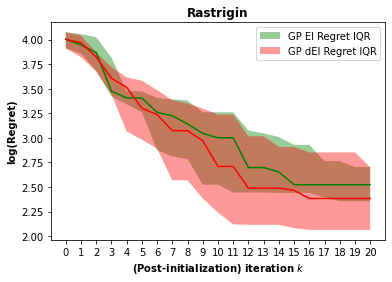

In [ ]:
### Visualize!

title = 'Rastrigin'

plt.figure()

plt.plot(median_approx, color = 'Green')
plt.plot(median_exact, color = 'Red')

xstar = np.arange(0, iters+1, step=1)
plt.fill_between(xstar, lower_approx, upper_approx, facecolor = 'Green', alpha=0.4, label='GP EI Regret IQR')
plt.fill_between(xstar, lower_exact, upper_exact, facecolor = 'Red', alpha=0.4, label='GP dEI Regret IQR')

plt.title(title, weight = 'bold', family = 'Arial')
plt.xlabel('(Post-initialization) iteration $\it{k}$', weight = 'bold', family = 'Arial') 
plt.ylabel('log(Regret)', weight = 'bold', family = 'Arial') 
plt.legend(loc=1) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(0, count))
plt.show() #visualize!

In [ ]:
time_approx, time_exact

(814.9613211154938, 82.01042890548706)